# A Procedure for Fitting Wide-Band Features in Filterbank Spectra and Identifying RFI-Like Features

by Umran Haji, Undergraduate Research Intern

---

## What is This and What is the Point of It?

Before you can hope to find ET, you need to be able to find radio frequency interference (RFI), i.e. all the man-made signals that "clutter" our data. With that in mind, we at Breakthrough Listen would like to have a way (or multiple different ways) of looking at power spectra and picking out the features that resemble RFI, i.e. features that are narrowly confined in frequency space and that are clearly not produced by blackbody stellar radiation.

There are a lot of ways one could imagine "picking out" the so-called "narrow-band" features of a spectrum. In this Jupyter notebook, I comprehensively describe a method that I have been working on for several months. This method is essentially a very complicated, multi-step curve-fitting procedure that captures the general shape of a spectrum but that is insensitive to narrow-band features, and then uses the generated fit to "reduce" the spectrum such that almost all the variation in power that remains is due to the presence of these narrow-band features and noise. The reduced spectrum is then amenable to further analysis via a thresholding procedure. 

This sounds very abstract, so let's dive right in with an example. Below I load in a test `filterbank` file and plot the power spectrum, summed over the whole time axis.

<IPython.core.display.Javascript object>


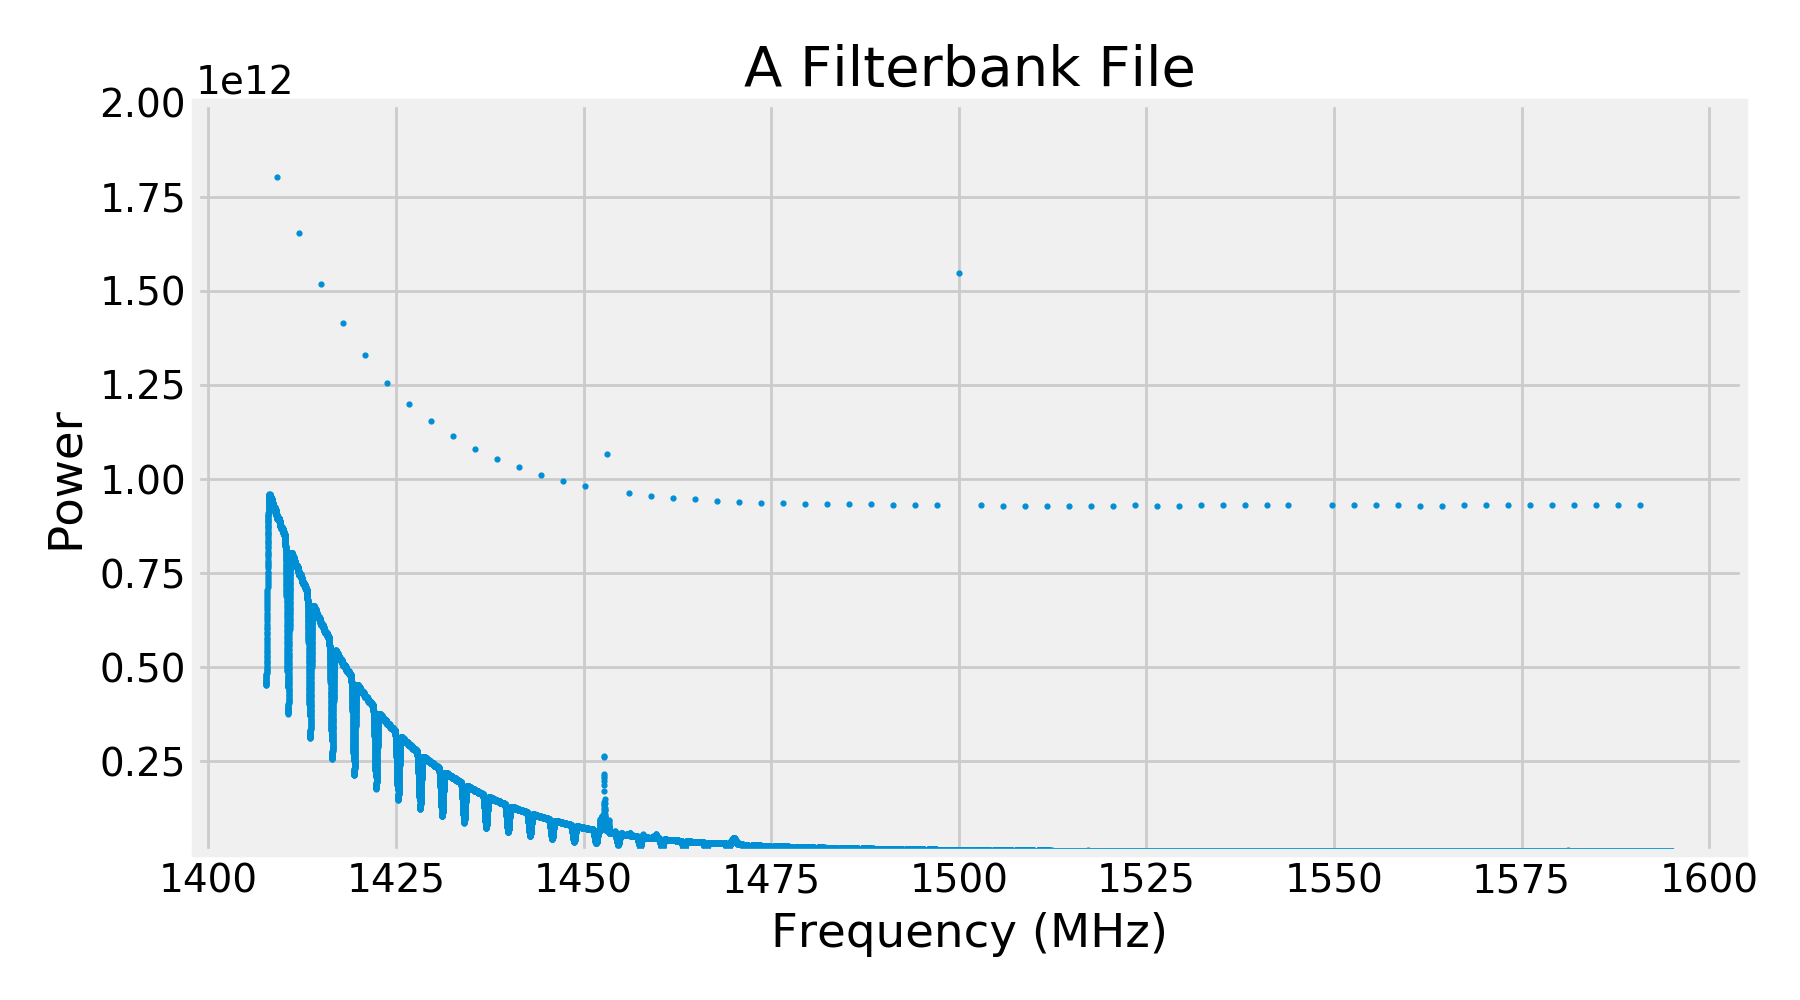

In [52]:
%matplotlib notebook
from filterbank import Filterbank, read_header
import numpy as np
import matplotlib.pyplot as plt
import itertools, json
from astropy.stats.sigma_clipping import sigma_clip
from scipy.optimize import curve_fit

plt.style.use('fivethirtyeight')
file = 'blc01_guppi_57511_22276_HIP70434_0016.gpuspec.0002.fil'
fil = Filterbank(file)
data = np.sum(fil.data, axis=0)[0] #Sum the data over the whole time axis
freqs = fil.freqs

plt.figure(figsize=(9,5)); plt.scatter(freqs, data, s=3); plt.ylim(min(data), 2e12)
plt.xlabel("Frequency (MHz)"); plt.ylabel("Power"); plt.title("A Filterbank File")
plt.tight_layout()

With this example firmly on the table, we can talk more tangibly about what we're after: As you can see, the spectrum has a general trend to it. In this case, it starts out pretty high on the low end of the spectrum and decreases in a manner that looks very roughly exponential. The general shape is due almost entirely to the blackbody spectrum of the target.

Now, see that little spike around 1453 MHz? That is what I am calling a "narrow-band" feature. Those are the kind of features that we want to pick out (obviously, not all such features will be RFI; some may be spectral lines. But the point is, we want to come up with a way of detecting features that generally look like this. 

Incidentally, 1453 was the year Byzantium finally fell to the Ottomans, and we are about to develop a procedure of Byzantine complexity to identify narrow-band features, so I suppose this example is telling. 

## 1. Stationarizing the Spectrum

The first thing we want to do is transform the spectrum so as to eliminate the general trend, such that all that remains is periodic variations, the noise, and the occasional narrow-band feature. Eliminating this general trend is called "stationarizing" the data.

Why do we want to stationarize the data in the first place? Because it will allow us to then take advantage of the periodicity of the spectrum by fitting a Fourier series to the flattened ("stationarized") spectrum which will capture the bandpass shape while ignoring the narrow-band features.

To start, a good first step is to make the periodic features have the same amplitude. Notice that the depths of the troughs appear to vary in a systematic way; at frequencies where the power level is higher, the troughs are deeper. So it is prudent to take the log of the spectrum and hope it makes the amplitudes constant.

<IPython.core.display.Javascript object>


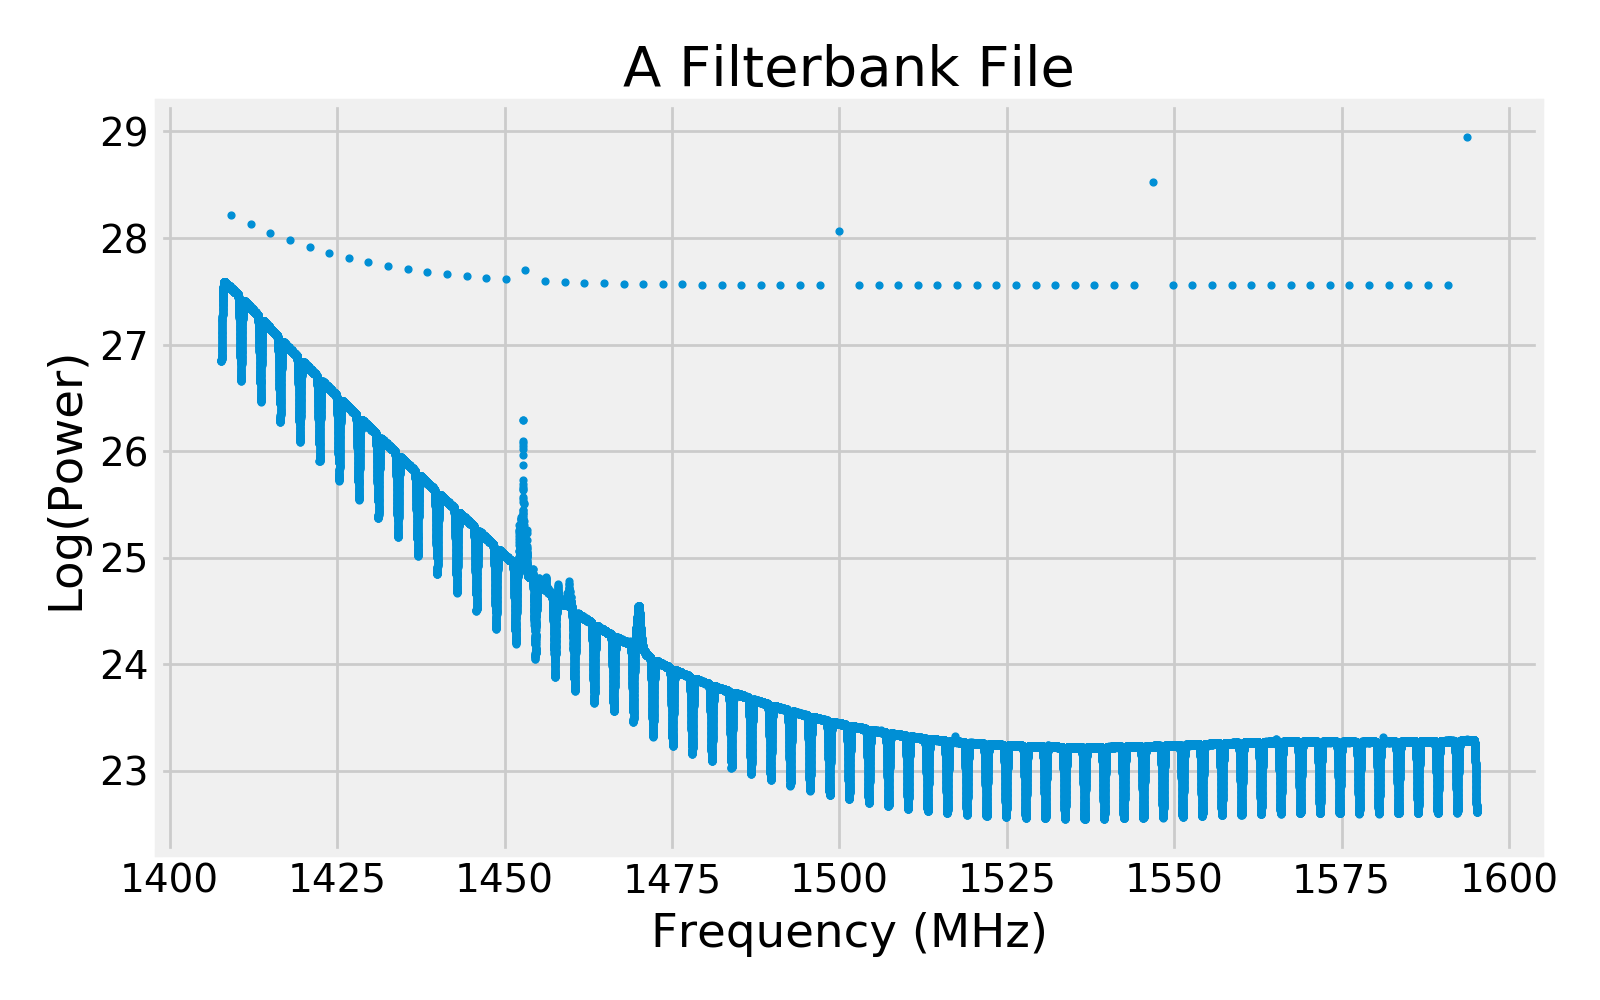

In [2]:
plt.figure(figsize=(8,5))
plt.scatter(freqs, np.log(data), s=6)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Log(Power)")
plt.title("A Filterbank File"); plt.tight_layout()

Progress! Taking the log managed to essentially equalize all the trough amplitudes. The next thing to do is detrend the spectrum. We will do this by fitting a spline to a few representative points in each coarse channel, and then subtracting this spline from the spectrum. 

The precise way in which I decided to make the spline was determined by trial and error: For each coarse channel, we plot one point near the left edge, one in the center, and one near the right edge. Their vertical positions (i.e. their power values) are determined by assigning to them the vertical positions associated with a few points at certain carefully-chosen percentiles.

As a precaution to prevent the spline from misbehaving, after obtaining the representative points, we "pad" the data by adding additional such points on either side of the spectrum so that the spline has to fit to them.

<IPython.core.display.Javascript object>


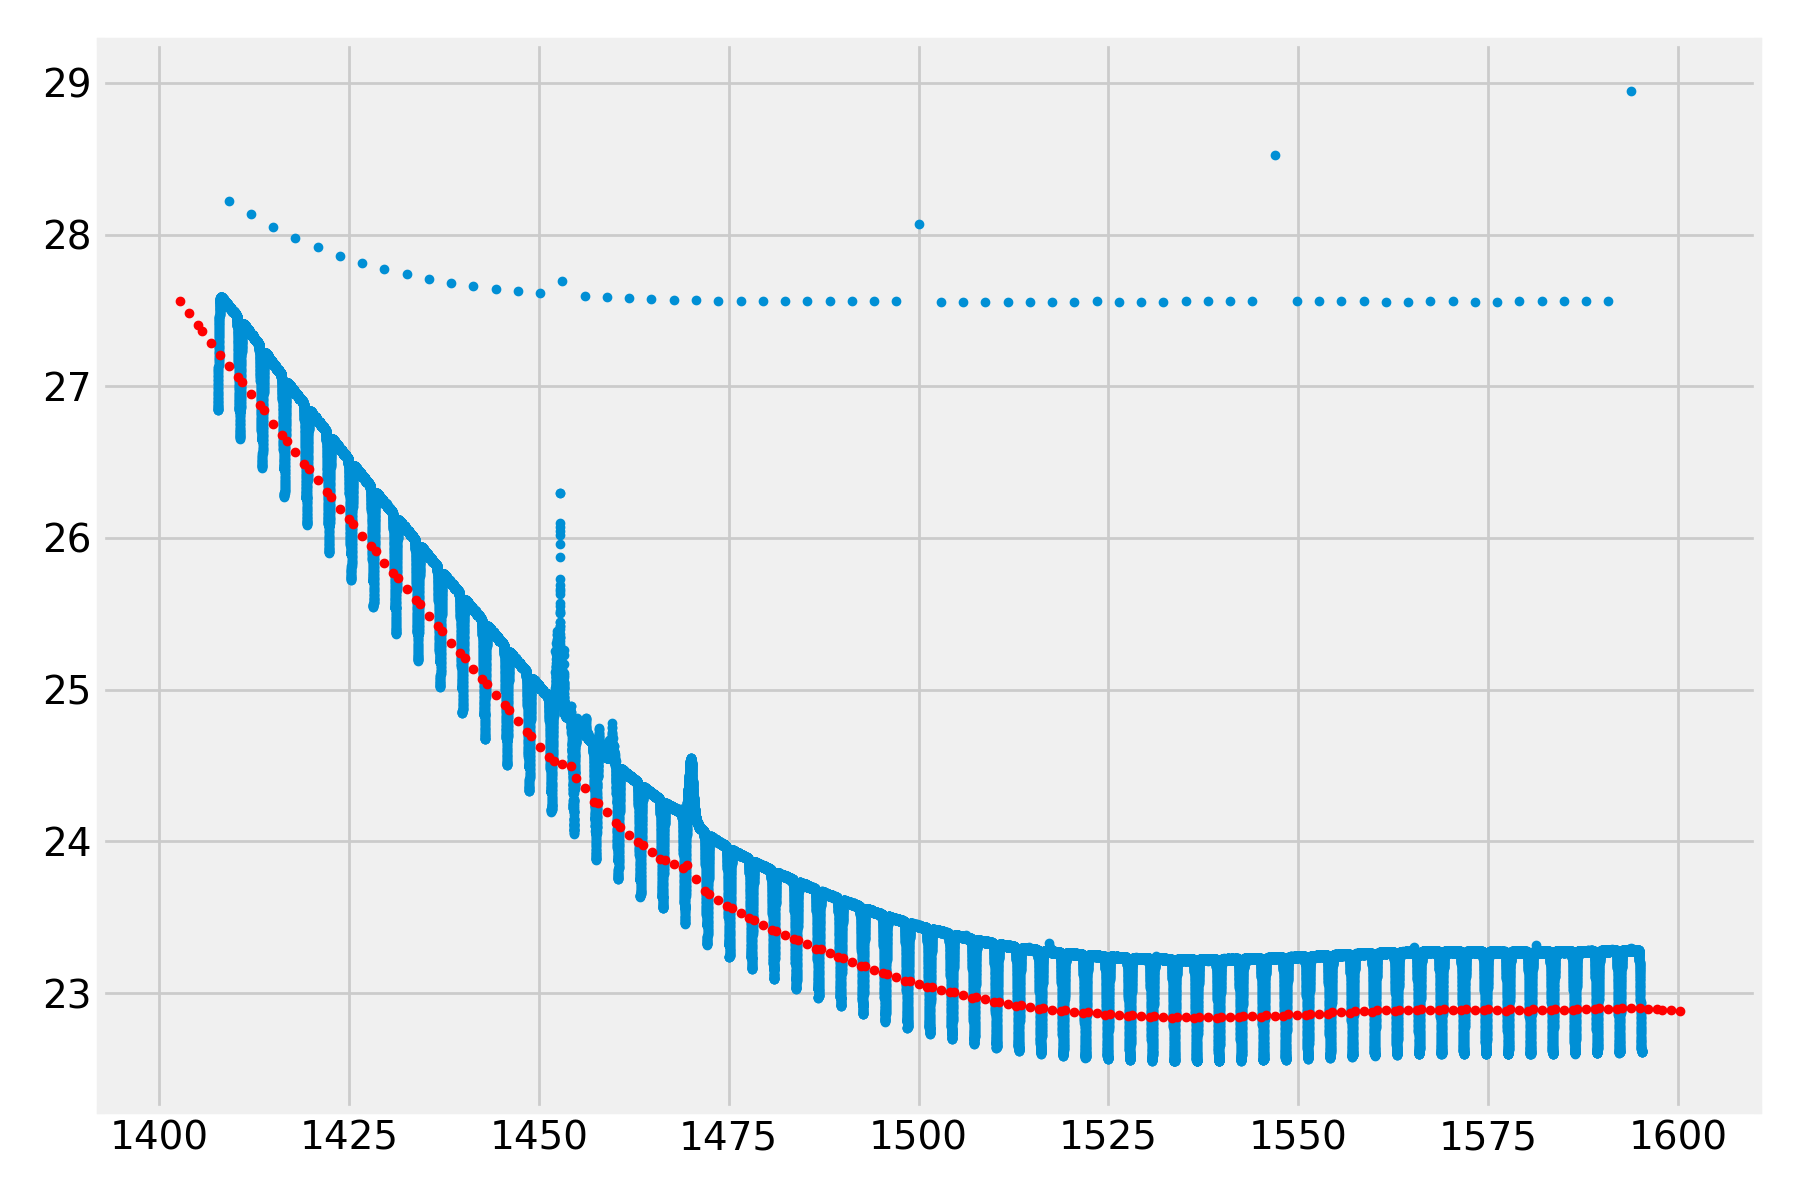

In [3]:
def findline(p1, p2):
    #Returns the slope and intercept of line connecting two given points
    #p1 and p2 must be length-2 iterables containing the (x,y) coordinates
    x1, y1 = p1
    x2, y2 = p2
    m = (y2 - y1)/(x2 - x1) #slope
    b = y1 - m*x1 #intercept
    return m, b

def pad_data(x, y, n_pad = int(5)):
    #Pad data by simply extending a line in both directions with slope given by
    #the two points on each end of the data. n_pad is the no. of points to add on each side
    
    first_two_x = x[0:2]
    first_two_y = y[0:2]
    first_two_points = np.dstack([first_two_x, first_two_y])[0]
    left_m, left_b = findline(first_two_points[0], first_two_points[1]) #slope, intercept for left side

    last_two_x = x[-2:]
    last_two_y = y[-2:]
    last_two_points = np.dstack([last_two_x, last_two_y])[0]
    right_m, right_b = findline(last_two_points[0], last_two_points[1])

    left_pad_x = np.array(x[0:n_pad]) - (x[n_pad]-x[0])
    left_pad_y = left_m*left_pad_x + left_b
    right_pad_x = np.array(x[-n_pad:]) + (x[n_pad]-x[0])
    right_pad_y = right_m*right_pad_x + right_b

    padded_x = np.array(list(itertools.chain(left_pad_x, x, right_pad_x)))
    padded_y = np.array(list(itertools.chain(left_pad_y, y, right_pad_y)))

    return padded_x, padded_y

def CC_points(x, y):
    #Create a set of points from each coarse channel, to be used for plotting a spline.
    #x and y are 1-D iterables of equal length. Typically x will be the frequency array
    #and y the power array (of the entire spectrum). 
    x = np.array(x)
    y = np.array(y)
    num_CCs = int(len(x)/1024) #The number of coarse channels, since each one has length 1024
    
    #Make array of integers and split it into however many coarse channels there are
    coarsechans = np.split(np.arange(len(x)), num_CCs)

    yvals = []
    xvals = []
    for chan_idx in coarsechans:
        chanfreqs = x[chan_idx] #Frequencies for this coarse channel
        chanpowers = y[chan_idx] #Power values for this coarse channel
        
        power1 = np.percentile(chanpowers[0:255], 20)
        power2 = np.percentile(chanpowers, 10)
        power3 = np.percentile(chanpowers[-255:], 20)
        
        powers = [power1, power2, power3]
        freqs = np.percentile(chanfreqs, [10,50,90])
        
        for f in freqs:
            xvals.append(f)
        
        for p in powers:
            yvals.append(p)
    
    #To prevent spline from misbehaving at edges, pad with points                                               
    xvals, yvals = pad_data(xvals, yvals)
    return xvals, yvals

xvals, yvals = CC_points(freqs, np.log(data))
plt.figure(figsize=(9,6))

plt.scatter(freqs, np.log(data), linewidth=1.5, zorder=1, s=4)   
for i in np.arange(len(xvals)):
    plt.scatter(xvals[i], yvals[i], zorder=2, color='red', s=9)
plt.show(); plt.tight_layout()

The red points are the representative points we just discussed. As we can see, the plotted points do a reasonably good job of capturing the trend while mostly ignoring any narrow features that show up. However, it so happens that there are some filterbank files in which ALL the points in a certain coarse channel are vertically offset upward by a huge amount. I have no idea why this occurs. In any case, when this happens it is not sufficient to simply place points at certain power percentiles because they will all be hugely shifted upward compared to the points in the surrounding coarse channels.

By trial and error I have developed a simple algorithm for mitigting this. For each of the red points above (except the "padding" ones on the end), we take the two red points on either side of it, and if it is too high above a line connecting the two on either side, we "drag it" down so that it lies on that line, by replacing its vertical position with a position interpolated from that line.

In [4]:
def clean_CC_points(xvals, yvals):
    #Now clean the representative points in each coarse channel, 
    #reject outliers and dragging down their positions                                                                                              
    for i in np.arange(5): #Do this same thing 5 times                                                                                          
        for i in np.arange(1, len(xvals)-1):
            previousp = np.array([xvals[i-1], yvals[i-1]]) #Point on the left
            currentp = np.array([xvals[i], yvals[i]]) #Current points in question
            nextp = np.array([xvals[i+1], yvals[i+1]]) #point on the right
            m, b = findline(previousp, nextp) #slope and intercept of a line connecting left and right points
            interpolatedp = np.array([xvals[i], m*xvals[i]+b]) #what the power level would be if on this line

            #If current actualy point is higher than both of the two on the sides, 
            #and the distance between it and the line connecting the two 
            #is sufficiently large, replace its y value. with the interpolated one
            if (currentp[1] > previousp[1] and currentp[1] > nextp[1]) and \
            currentp[1]-interpolatedp[1] > .01*np.linalg.norm(currentp - previousp) \
            and currentp[1] > interpolatedp[1]:
                #Replace current point with interpolation                                                       
                m, b = findline(previousp, nextp)
                yvals[i] = m*xvals[i]+b
    return xvals, yvals        

xvals, yvals = clean_CC_points(xvals, yvals)

In our case, all of the points are already well-behaved, so this had no effect, but it will be useful for other files.

We are now ready to produce a spline fit to the red points:

<IPython.core.display.Javascript object>


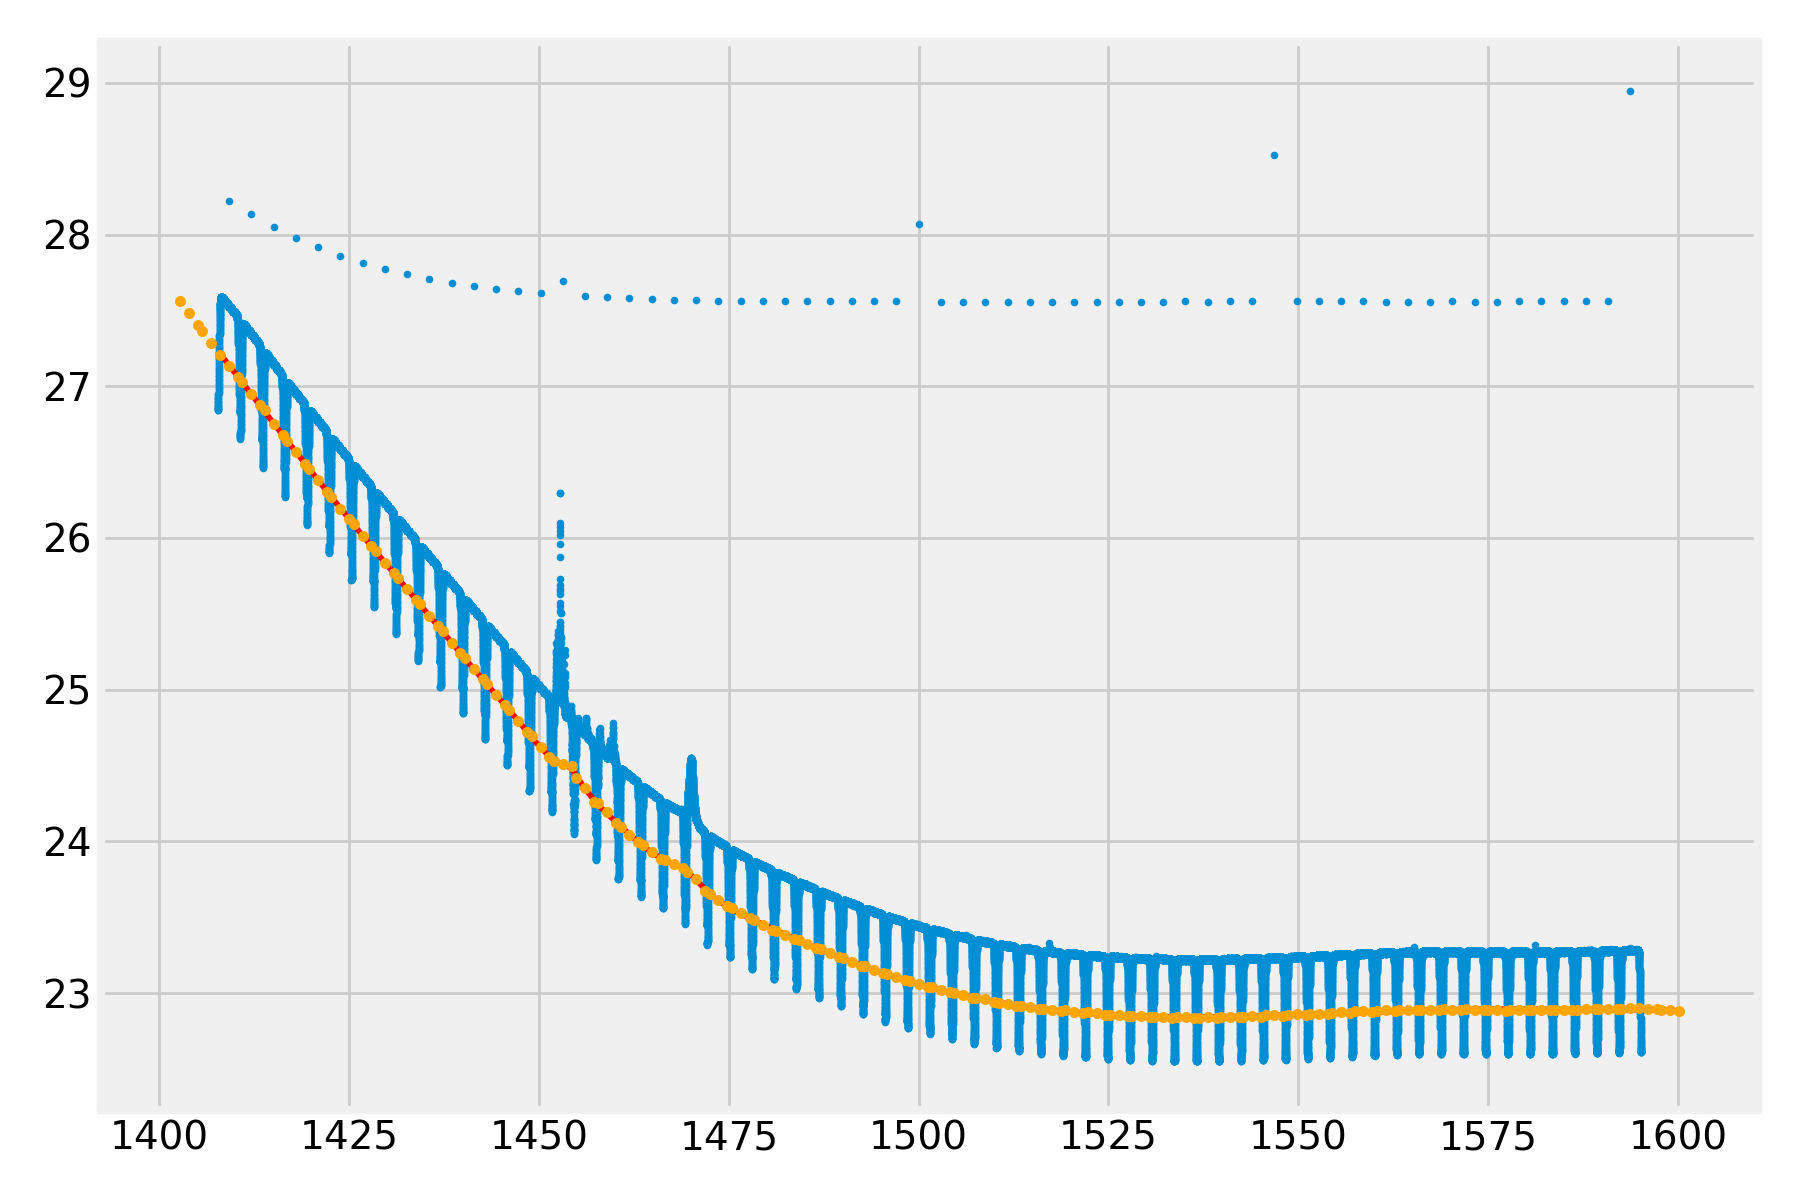

In [5]:
from scipy.interpolate import UnivariateSpline
import scipy

%matplotlib notebook
def trend_spline(x,y,k=3):
    #x is the frequency array, y is power. k is the order of the polynomials
    #used for the spline.
    initial_x, initial_y = CC_points(x, y)
    cleaned_x, cleaned_y = clean_CC_points(initial_x, initial_y)
    
    #Build spline                                                                                                                               
    N=len(x); rmserror=.00001
    #This just sets the tolerance for how close the spline must be to the given points. s is
    #a parameter that is related to how many nodes there are in the spline.
    s = N*(rmserror * np.fabs(cleaned_y).max())**2
    spl = UnivariateSpline(cleaned_x, cleaned_y, s=s, k=k)
    return cleaned_x, cleaned_y, spl

x, y, spline = trend_spline(freqs, np.log(data))
plt.figure(figsize=(9,6))
plt.scatter(freqs, np.log(data), s=5)
plt.plot(freqs, spline(freqs), color='red', linewidth=2)
plt.scatter(x, y, s=12, color='orange', zorder=3); plt.tight_layout()

Finally, we detrend the data by simply subtracting this spline fit from the data.

<IPython.core.display.Javascript object>


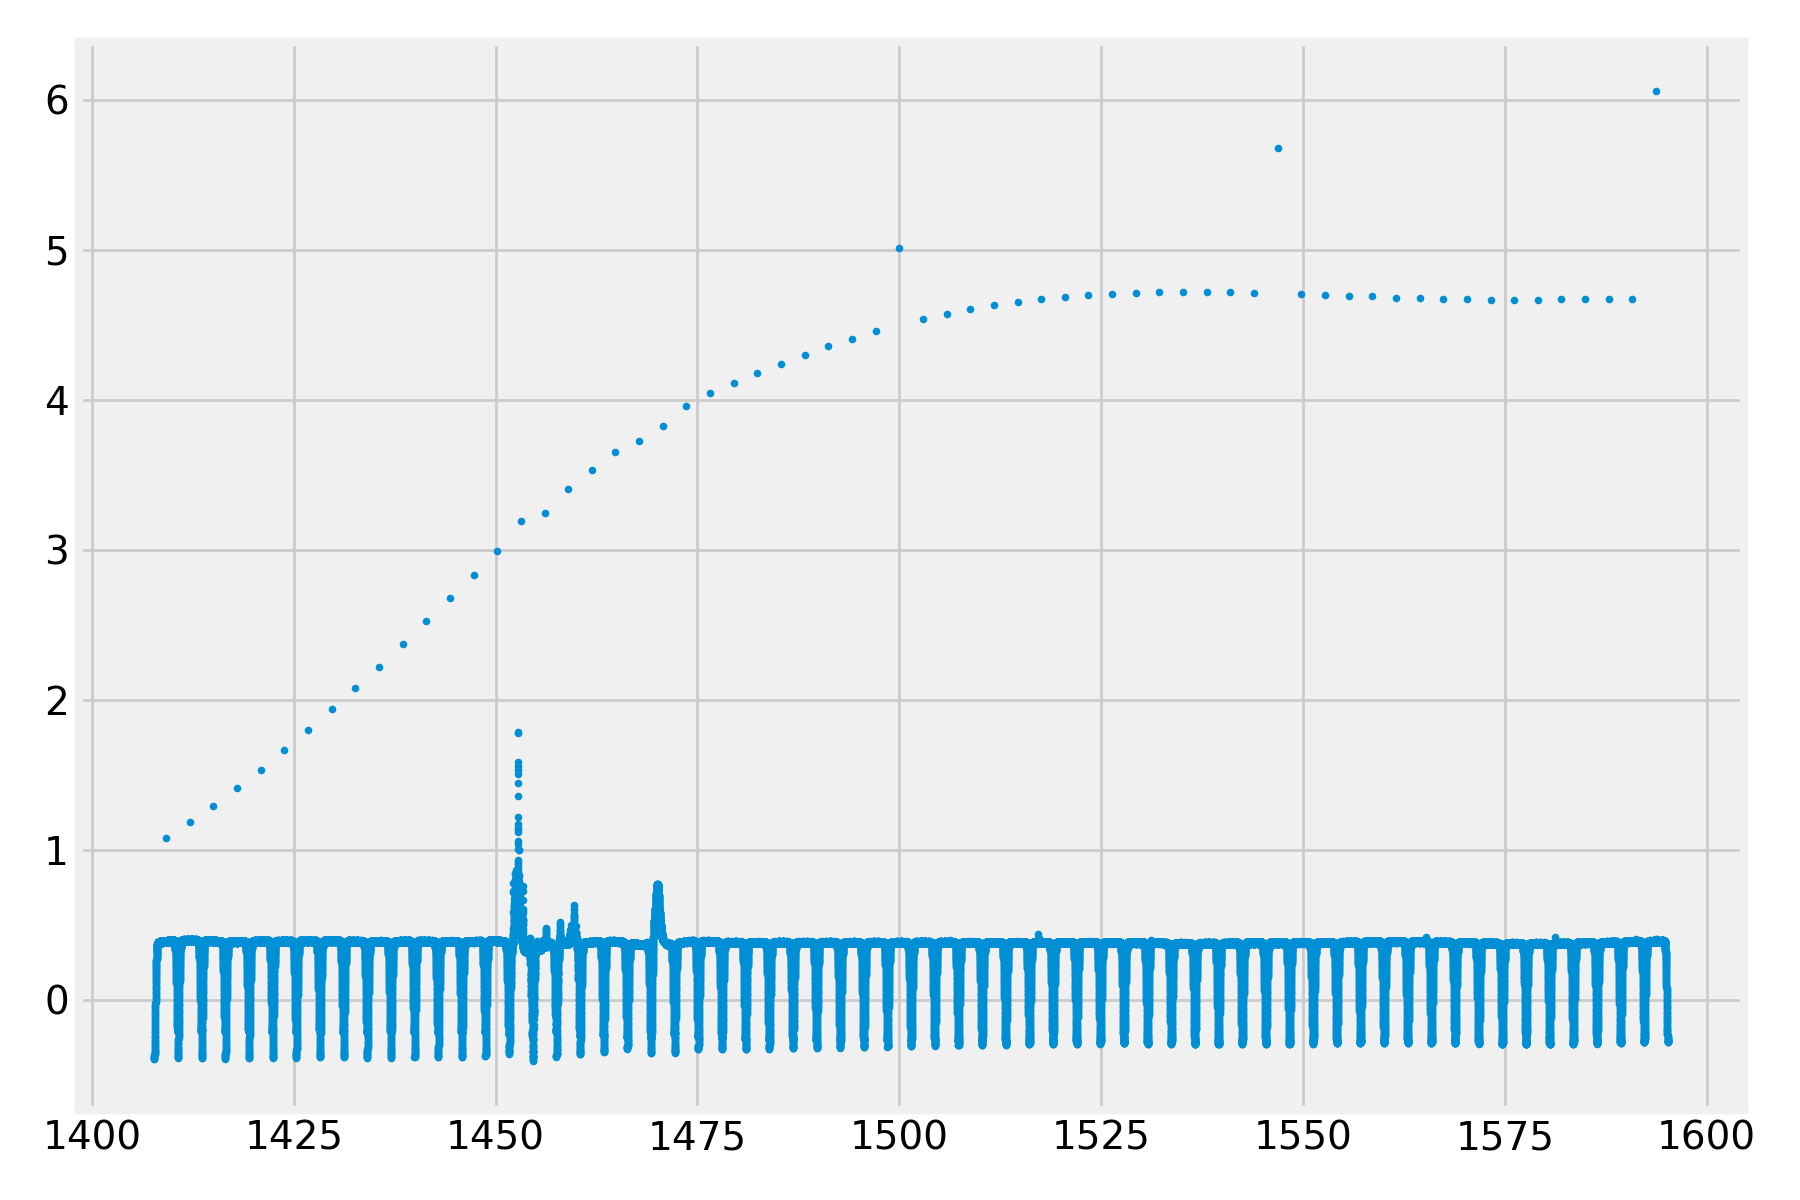

In [6]:
%matplotlib notebook
logged_minus_spline = np.log(data) - spline(freqs)
detrended = logged_minus_spline
plt.figure(figsize=(9,6))
plt.scatter(freqs, logged_minus_spline, s=5); plt.tight_layout()

## Sigma Clipping the Stationary Spectrum

Now that we have the data in a nice stationary form, we are nearly in a position to take advantage of the periodicity and create a fit to the bandpass filter shapes. Before we do that, though, it will be helpful to eliminate the narrow-band features. Now that the spectrum is stationarized, we can eliminate these features with a simple sigma-clipping approach.

We use the `sigma_clip` function from astropy, but with a wrapper function around it. The reason for the wrapper is that `sigma_clip` returns the clipped data in the form of a masked numpy array rather than deleting the clipped values entirely, but it turns out that later parts of our analysis do not play nicely with this mask and act as if the array was never clipped at all. So the purpose of the wrapper is to manually remove the masked values entirely and save the indices of the values that were removed.

<IPython.core.display.Javascript object>


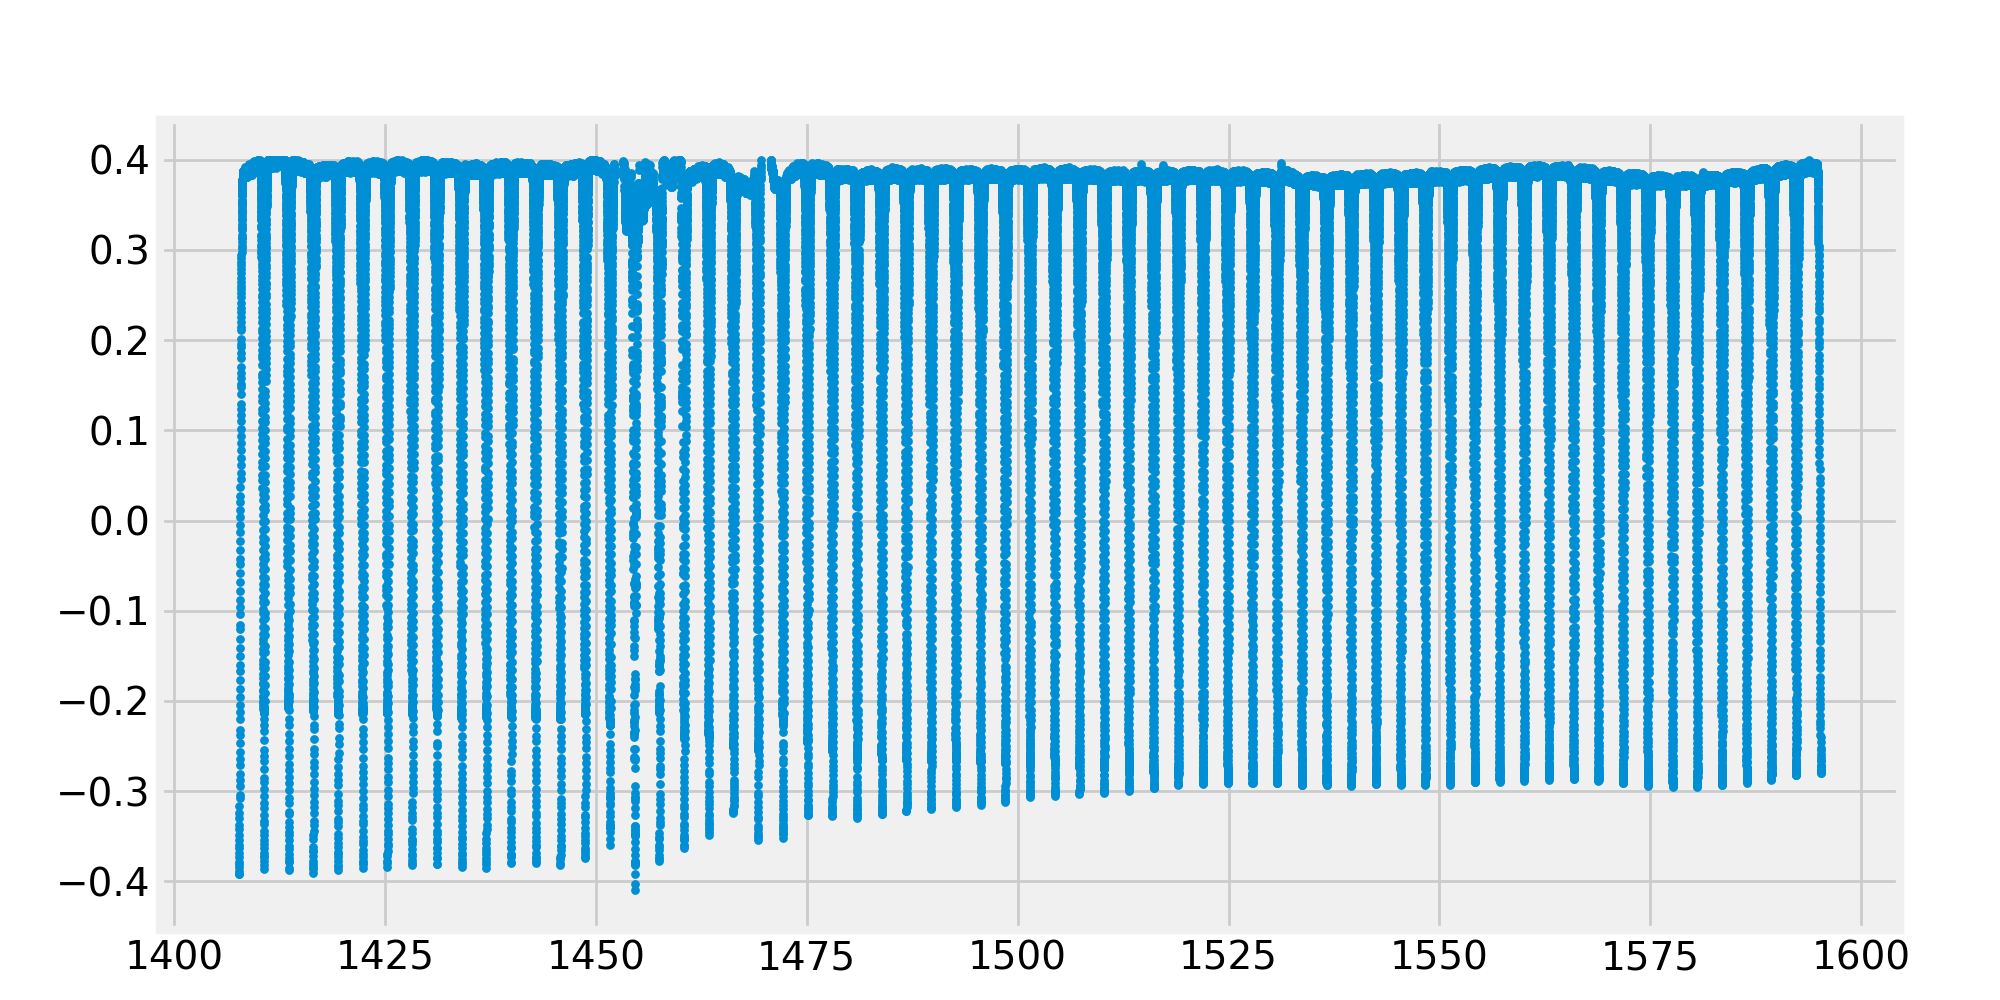

In [7]:
%matplotlib notebook
def clip(x, y, sigma_lower=5, sigma_upper=.1):
    clipped = sigma_clip(y, sigma_lower=sigma_lower, sigma_upper=sigma_upper) #Determined the 
    #thresholds by trial and error
    rejected = np.ma.getmask(clipped)
    idx_rejected = np.where(rejected)[0] #indices of clipped values
    clipped_data = np.delete(y, idx_rejected)
    clipped_freqs = np.delete(x, idx_rejected)
    return clipped_freqs, clipped_data, idx_rejected
    
clipped_freqs, clipped_data, idx_rejected = clip(freqs, detrended)
plt.figure(figsize=(10,5))
plt.scatter(clipped_freqs, clipped_data, s=7)

## Fitting a Fourier Series

The detrended and almost perfectly periodic series of data points that we now have is something that is very easy to work with. What we want to do next is take advantage of the periodicity in the data by coming up with a Fourier series that captures this periodicity. We can save a finite number of the terms in that series and use them to create the same periodic fit to every file, because each one will have the same inherent periodicity once the trend is removed.

So, first we identify a quiet region of this spectrum:

<IPython.core.display.Javascript object>


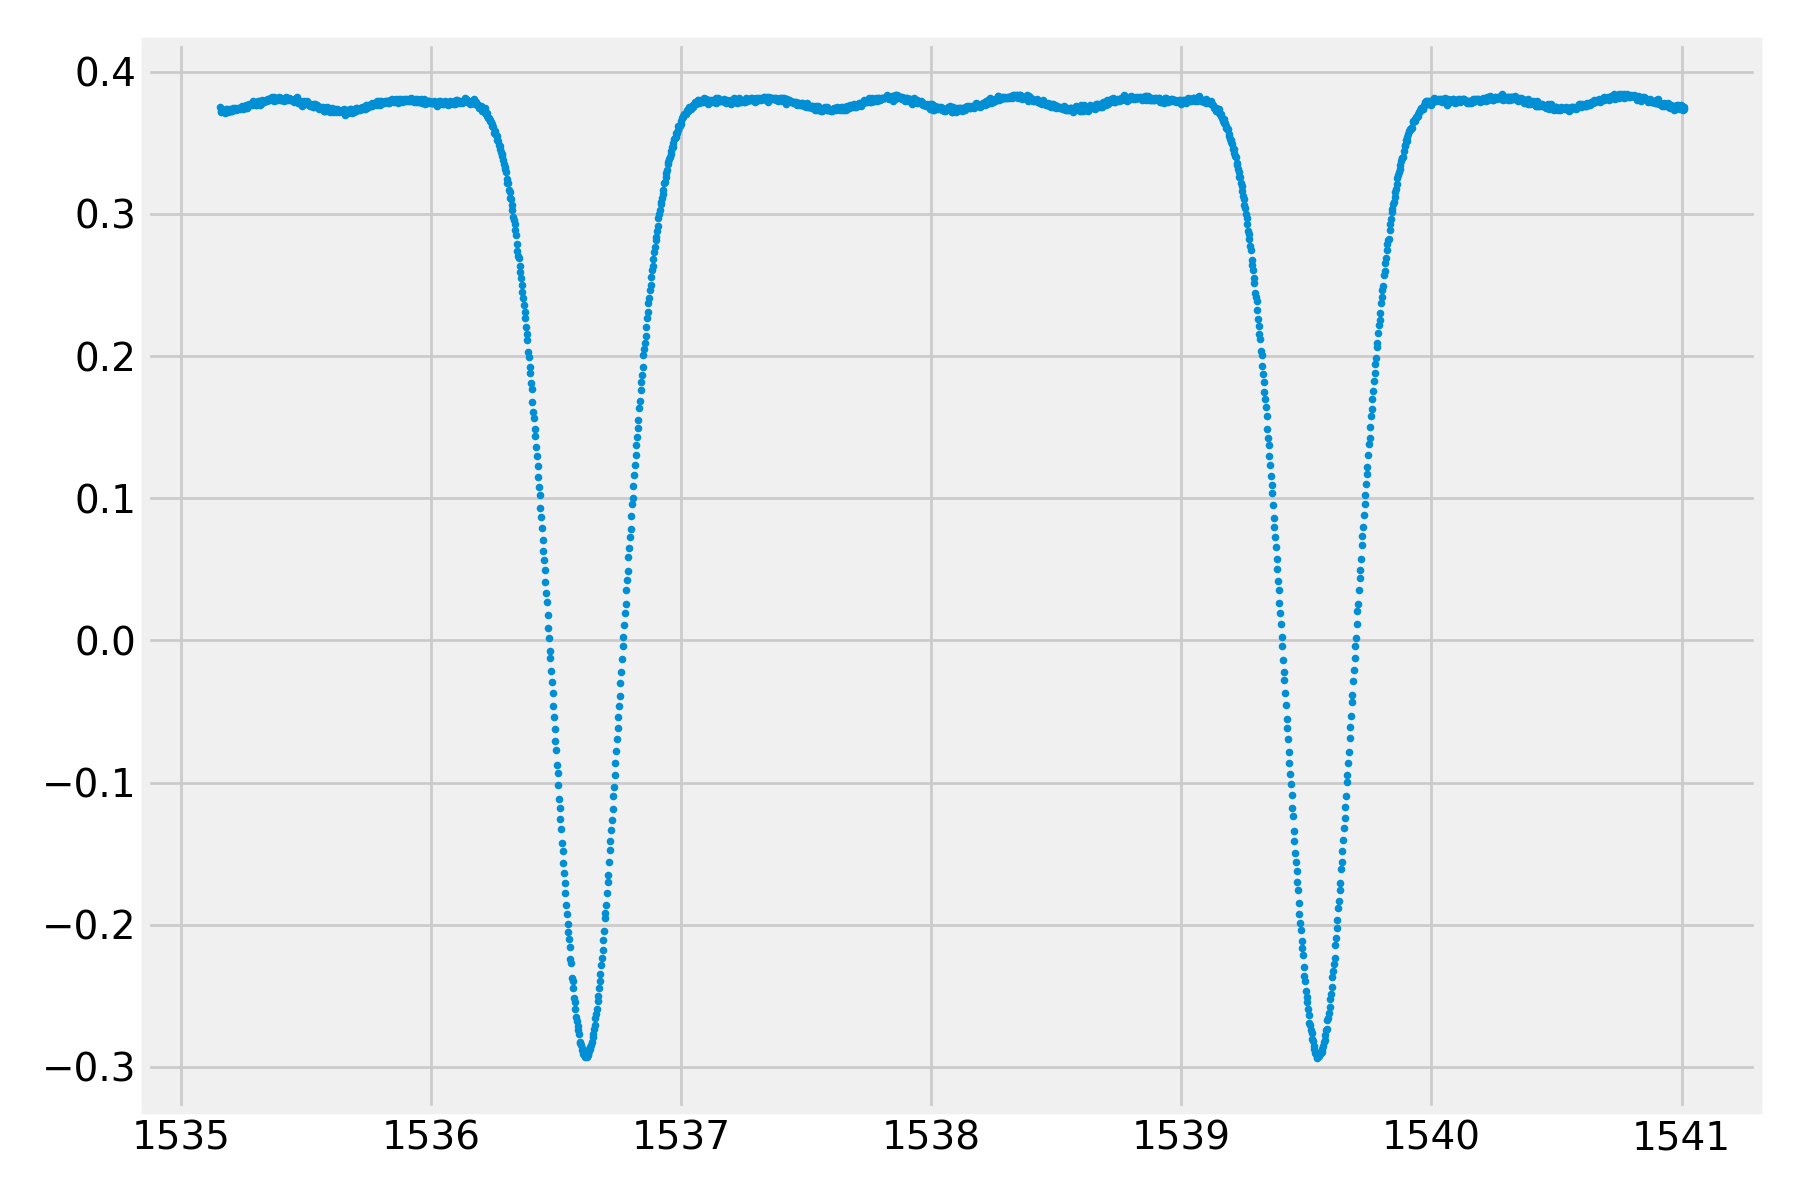

In [8]:
# The far right part of the spectrum looks very quiet and seems promising. 
#So here we choose indices for a coarse channel from that region.
#I chose this specific region by trial and error until I got one that looked as
#quiet as possible

start = -1 + 512*86 + 512 
end = start + 2*512*2 #take 2 coarse channels (each is 1024 frequency bins long)

quiet_section_freqs = freqs[start:end]
quiet_section_powers = detrended[start:end]

#We'll get rid of the DC spikes so they don't interfere with our Fourier decomposition.
#A simple way to do this is to just set those frequency values to have the power values
#associated with the immediately preceding points.
for i in np.arange(len(quiet_section_freqs)):
    if quiet_section_powers[i] > 3: #This threshold was determined visually
        quiet_section_powers[i] = quiet_section_powers[i-1] #replace it with previous power value

plt.figure(figsize=(9,6))
plt.scatter(quiet_section_freqs, quiet_section_powers, s=5)
plt.tight_layout()

Now we have a nice clean piece of spectrum on which to do some Fourier analysis! You don't need to worry about the details much, but below I use an FFT to identify the most prominent frequencies of this periodic data, extract the amplitudes, frequencies, and phase values, and use all these parameters to construct a truncated Fourier series that I plot over this data:

<IPython.core.display.Javascript object>


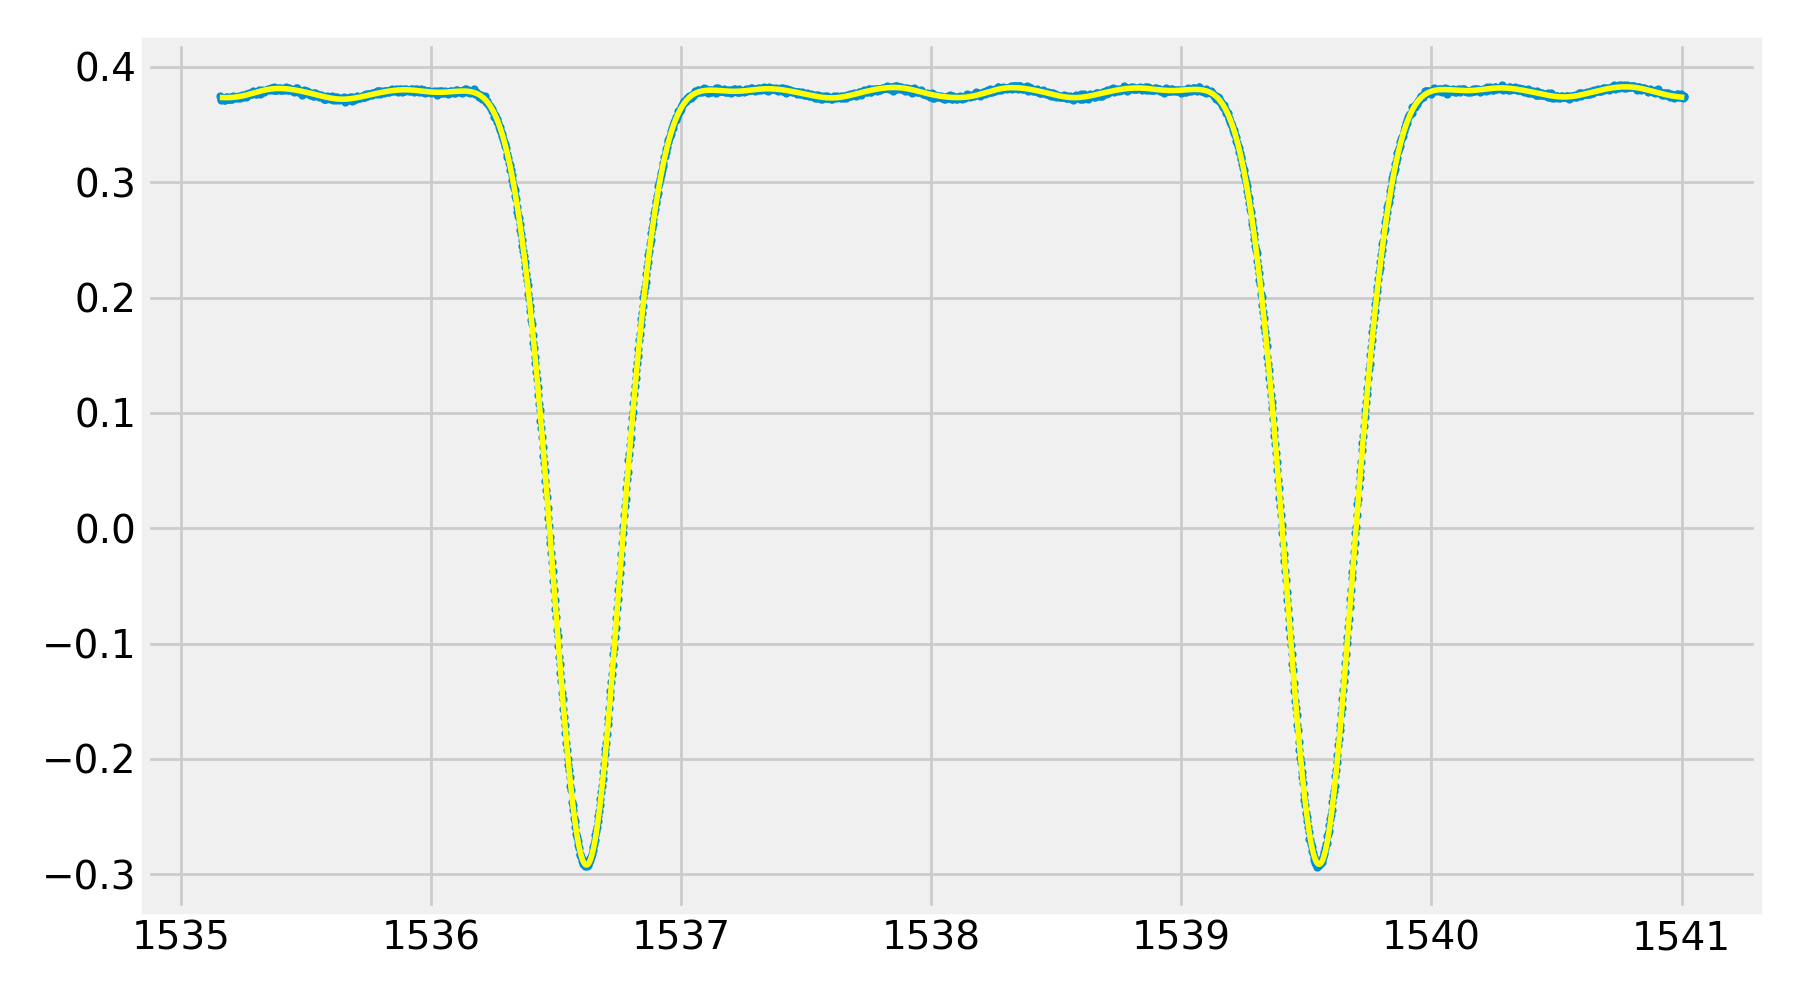

In [9]:
%matplotlib notebook
def fourier_components(x, y, n):
    FFT = np.fft.fft(y)/len(y)
    amplitudes = np.abs(FFT)
    freqs = np.fft.fftfreq(len(y),x[1]-x[0])
    phases = np.array([np.arctan2(item.imag, item.real) for item in FFT])
    
    #take n freqs with largest amplitudes
    max_idx = amplitudes.argsort()[-n:]
    max_freq = freqs[max_idx]
    max_phase = phases[max_idx]
    max_amp = amplitudes[max_idx]
    
    #This creates a list of tuples. Each tuple contains the amplitude, frequency, and phase offset of a
    #single component, i.e. a single term in the series
    params = np.dstack([max_amp, max_freq, max_phase])[0] 
    
    series = np.zeros(len(x)) #Make an array of zeros to which we will add the values from each term
    for i in np.arange(len(max_idx)):
        series += np.array([params[i][0]*np.cos(2*np.pi*params[i][1]*(val) + params[i][2]) for val in x])
    plt.figure(1, figsize=(9,5))
    plt.scatter(x, y, s=6)
    plt.plot(x, series, color='yellow', linewidth=2); plt.tight_layout()
    return params

#I used trial and error to determine to take the 35 highest-amplitude terms
fourier_tuples = fourier_components(quiet_section_freqs, quiet_section_powers, 35)   

This is quite tremendous. We were able to create an excellent fit to the periodic component of our spectrum! The shape of the Fourier fit is all but indistinguishable from the shape of the bandpass responses. This is a great success.

We can now simply save the parameters returned by the above function and use them in the future to build a Fourier series fit to any detrended filterbank spectrum (Note that it is not always going to be a perfect fit, simply because the degree to which each spectrum is successfully detrended will vary slightly). Just to give you a feel for what these are, I'll print the parameters below.

In [10]:
print fourier_tuples

[[  1.45910184e-04  -5.12000000e+00  -9.13409871e-03]
 [  1.45910184e-04   5.12000000e+00   9.13409871e-03]
 [  1.52190833e-04   5.12000000e-01   1.07350672e+00]
 [  1.52190833e-04  -5.12000000e-01  -1.07350672e+00]
 [  1.95888695e-04  -4.77866667e+00   3.14103082e+00]
 [  1.95888695e-04   4.77866667e+00  -3.14103082e+00]
 [  2.86001514e-04   1.70666667e-01   1.84392769e+00]
 [  2.86001514e-04  -1.70666667e-01  -1.84392769e+00]
 [  3.59419686e-04  -4.43733333e+00  -7.95485121e-02]
 [  3.59419686e-04   4.43733333e+00   7.95485121e-02]
 [  5.65845229e-04  -4.09600000e+00   3.13781141e+00]
 [  5.65845229e-04   4.09600000e+00  -3.13781141e+00]
 [  9.38707565e-04  -3.75466667e+00  -4.31429012e-02]
 [  9.38707565e-04   3.75466667e+00   4.31429012e-02]
 [  1.54074545e-03  -3.41333333e+00   3.13374992e+00]
 [  1.54074545e-03   3.41333333e+00  -3.13374992e+00]
 [  2.60211486e-03  -3.07200000e+00  -1.73422453e-02]
 [  2.60211486e-03   3.07200000e+00   1.73422453e-02]
 [  4.40826323e-03  -2.73066

Each of the 35 lines above is of the form $[a,b,c]$. Each line contains all the information corresponding to a single cosine term in a Fourier series. Each term is constructed by taking $a \cos{(2 \pi b x + c)}$. So the entire 35-term series is:

$$ y = \sum_{i=1}^{35} a_i \cos{(2 \pi b_i x + c_i)}$$

where x is the frequency and y is the approximate value of the (natural) logged and detrended spectrum at that particular frequency. Note that the entire thing may actually be off by an additive constant because the detrending process may not affect all spectra equally; they will all be roughly stationarized but they may have slightly different offsets. We will take care of this shortly when I show you how to use these tuples to generate the fit.

Now we store these parameters for later use:

In [11]:
with open('fourier_tuples.json', 'w') as f:
    json.dump(fourier_tuples.tolist(), f)

Now, in this case the Fourier series that we have generated is perfectly aligned with this file, and in general it is true that all coarse-frequency filterbank files will have the same underlying periodicity, BUT I have discovered some filterbank files in the past in which the periodicity had a phase offeset. When plotting the above Fourier series on those spectra, the Fourier series turned out to be shifted half a coarse channel to the left or right, relative to the spectrum itself. I am not sure why some files are like this, but I prevent against it by introducing some code below that varies the phase shift and performs a least-squares fit to determine the proper value of the shift for the file.

While we do not need to do it for this file because we already know the Fourier series is horizontally positioned correctly, I will do it anyway to show how it works. The procedure I've developed is as follows: First identify the quietest coarse channel in the detrended logged spectrum (which I define as the coarse channel in which the variance of the power values is the smallest). Then fit one period of the Fourier series to this coarse channel, varying the phase shift until a phase shift is found that minimizes a least-squares loss function (we do this with SciPy's `curve_fit` function). At the same time we also vary the vertical shift to determine the optimal constant to add. Once those two parameters are optimized, simply tile that single-period series end-to-end so that the number of tiles equals the total number of coarse channels in the spectrum. 

Fitting to a coarse channel to find optimal phase and offset...
Found phase and offset. Constructing full spectrum Fourier fit...


<IPython.core.display.Javascript object>


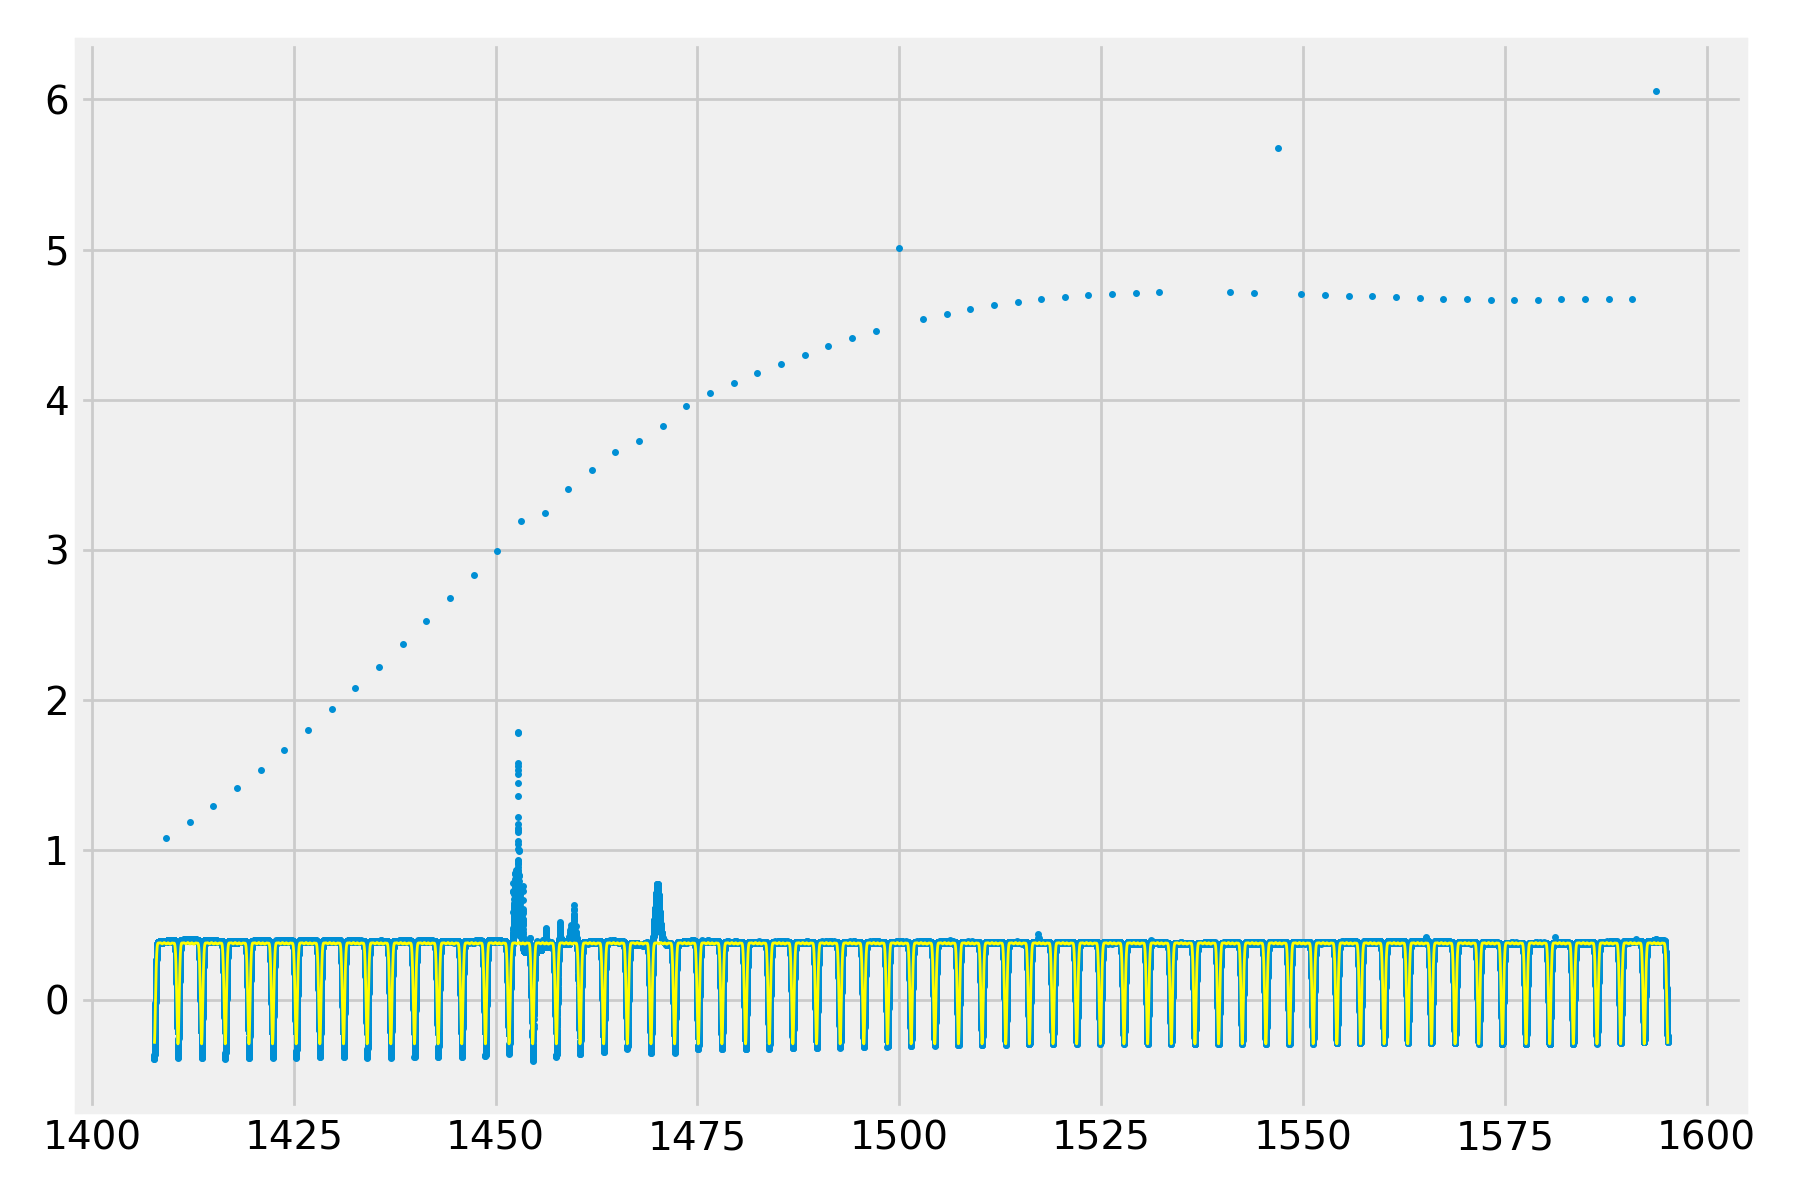

In [14]:
def fourier_fit(freqs, transformed_data):
    #transformed data is the logged, detrended, sigma clipped data.
    num_CCs = int(len(freqs)/1024) #number of coarse channels, since each one
    #is 1024 bins long
    coarsechans = np.split(np.arange(len(freqs)), num_CCs)

    #First find the coarse channel with smallest variance                                                                                                              
    chanvars = []
    for i in np.arange(len(coarsechans)):
        chan = coarsechans[i] #indices
        chanpowers = transformed_data[chan]
        chanvars.append(np.var(chanpowers))
        
    #Extract info for CC with smallest variance   
    quietest_chan_idx = chanvars.index(sorted(chanvars)[0])                                                     
    quietest_chan_powers = transformed_data[coarsechans[quietest_chan_idx]]
    quietest_chan_freqs = freqs[coarsechans[quietest_chan_idx]]
    
    
    
    #We don't want large values to impact the sum of squares and drag up the vertical offset. 
    #So first we sigma clip the data and we will feed the clipped version to the curve fit procedure.

    #This function is here purely for use by scipy.curve_fit
    def CC_fourier_fit(freqs_CC, D, C):
        #Fit one Fourier period to a quiet coarse channel, use this to determine phase and vertical shift.  
        #freqs_CC is the frequencies of this coarse channel
        fit = np.zeros(len(freqs_CC))
        for i in np.arange(len(fourier_tuples)): #Build Fourier series term-by-term
            fit += np.array([fourier_tuples[i][0]*np.cos(2*np.pi*fourier_tuples[i][1]*(val+D) +\
                                                                    fourier_tuples[i][2]) for val in freqs_CC])
        fit += np.array([C]*len(freqs_CC)) #Add constant vertical shift
        return np.array(fit)

    print "Fitting to a coarse channel to find optimal phase and offset..."
    parameters = curve_fit(CC_fourier_fit, quietest_chan_freqs, quietest_chan_powers, p0=(0,0))[0]
    fourier_CC = CC_fourier_fit(quietest_chan_freqs, *parameters)
    
    print "Found phase and offset. Constructing full spectrum Fourier fit..."
    #Tile the single-channel fit to get the fit for the entire spectrum
    fourier_fit = np.tile(fourier_CC, len(coarsechans))
    
    return fourier_fit

fit = fourier_fit(freqs, detrended)

#Plot the detrended spectrum and the fit over it
%matplotlib notebook
plt.figure(figsize=(9,6))
plt.scatter(freqs, detrended, s=4)
plt.plot(freqs, fit, color='yellow', linewidth=1); plt.tight_layout()

Now that we have fit our Fourier series to the detrended spectrum, all that's left to do is apply the inverse of the stationarization transformations to the fit, and we will obtain a fit to the original spectrum.

<IPython.core.display.Javascript object>


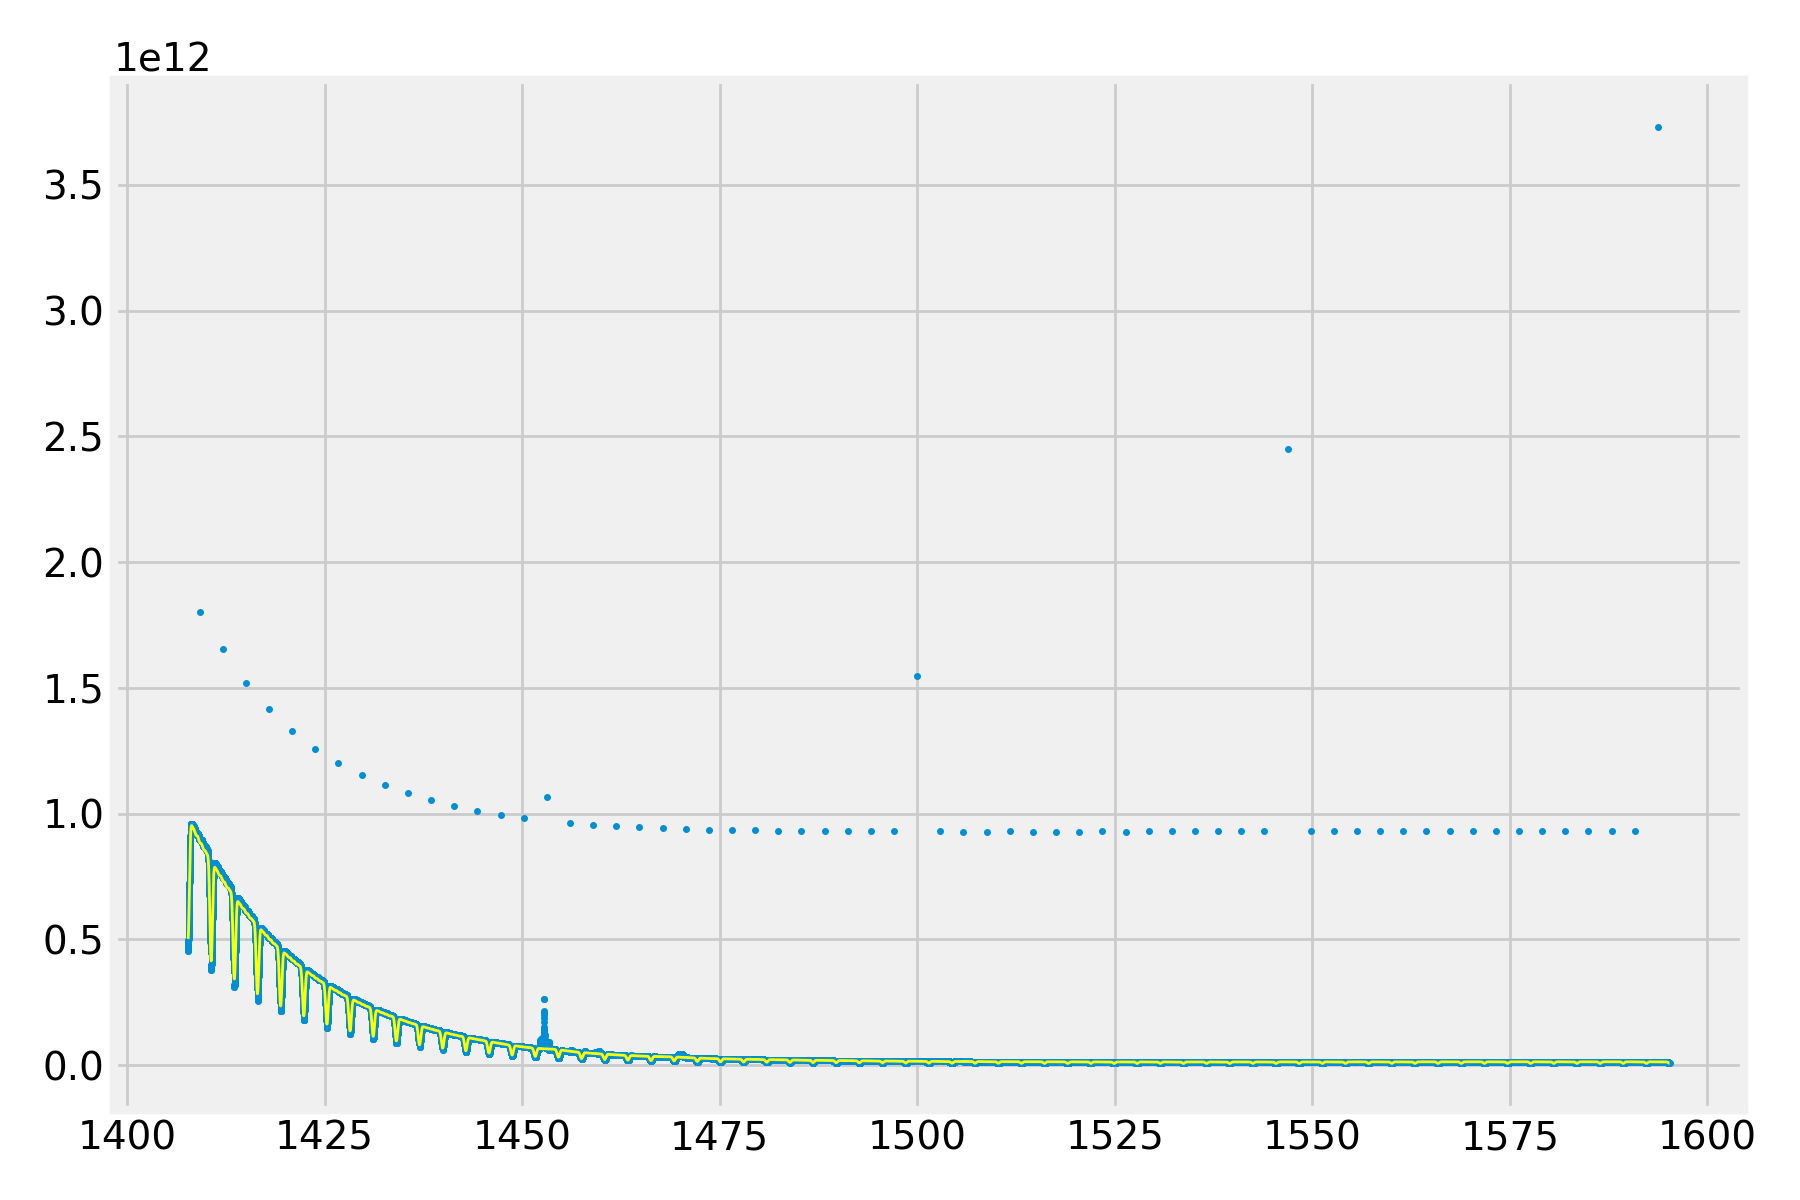

In [13]:
final_fit = np.exp(fit + spline(freqs))
%matplotlib notebook
plt.figure(figsize=(9,6))
plt.scatter(freqs, data, s=4)
plt.plot(freqs, final_fit, color='yellow', linewidth=1); plt.tight_layout()

And there we have it! In the next section we'll discuss how to incorporate this into a thresholding process to identify regions of interest in a spectrum. Before doing that, here I combine everything we have done so far to create a single function that generates the fit:

In [18]:
def fit_file_0002(file, integration=None, plot=False):
    #If integration is not provided, sum the power over the time axis.
    #Otherwise just get the power values for the given integration.
    if integration is not None:
        integration = int(integration)
        print "Getting data for integration {0}..." .format(integration)
        fil = Filterbank(file, t_start = integration, t_stop = integration + 1)
        data = fil.data[0][0]
    else:
        print "No integration number provided. Fitting summed spectrum..."
        fil = Filterbank(file)
        data = np.sum(fil.data, axis=0)[0]
    
    #Get frequencies
    freqs = fil.freqs
    
    #Log the data to equalize the heights of the troughs
    logged_data = np.log(data)
    
    #Get spikes
    last_index = len(freqs)-1
    spikes = np.arange(511, last_index, 1024)
    
    #Get CC points, create spline fit, detrend, and clip
    xpoints, ypoints, spl = trend_spline(freqs, logged_data)
    detrended = logged_data - spl(freqs)
    clipped_freqs, clipped_data, idx_rejected = clip(freqs, detrended)
    
    fit = np.exp(fourier_fit(freqs, detrended) + spl(freqs))
    print "Done fitting." + '\n'

    if plot:
        plt.figure(figsize=(9,6))
        plt.scatter(freqs, data, s=4)
        plt.plot(freqs, fit, color='yellow', linewidth=1)
        plt.grid()
        plt.tight_layout()
        plt.show()

    return np.array(freqs), np.array(data), np.array(fit)

freqs, data, fit = fit_file_0002(file)

No integration number provided. Fitting summed spectrum...
Fitting to a coarse channel to find optimal phase and offset...
Found phase and offset. Constructing full spectrum Fourier fit...
Done fitting.



<IPython.core.display.Javascript object>


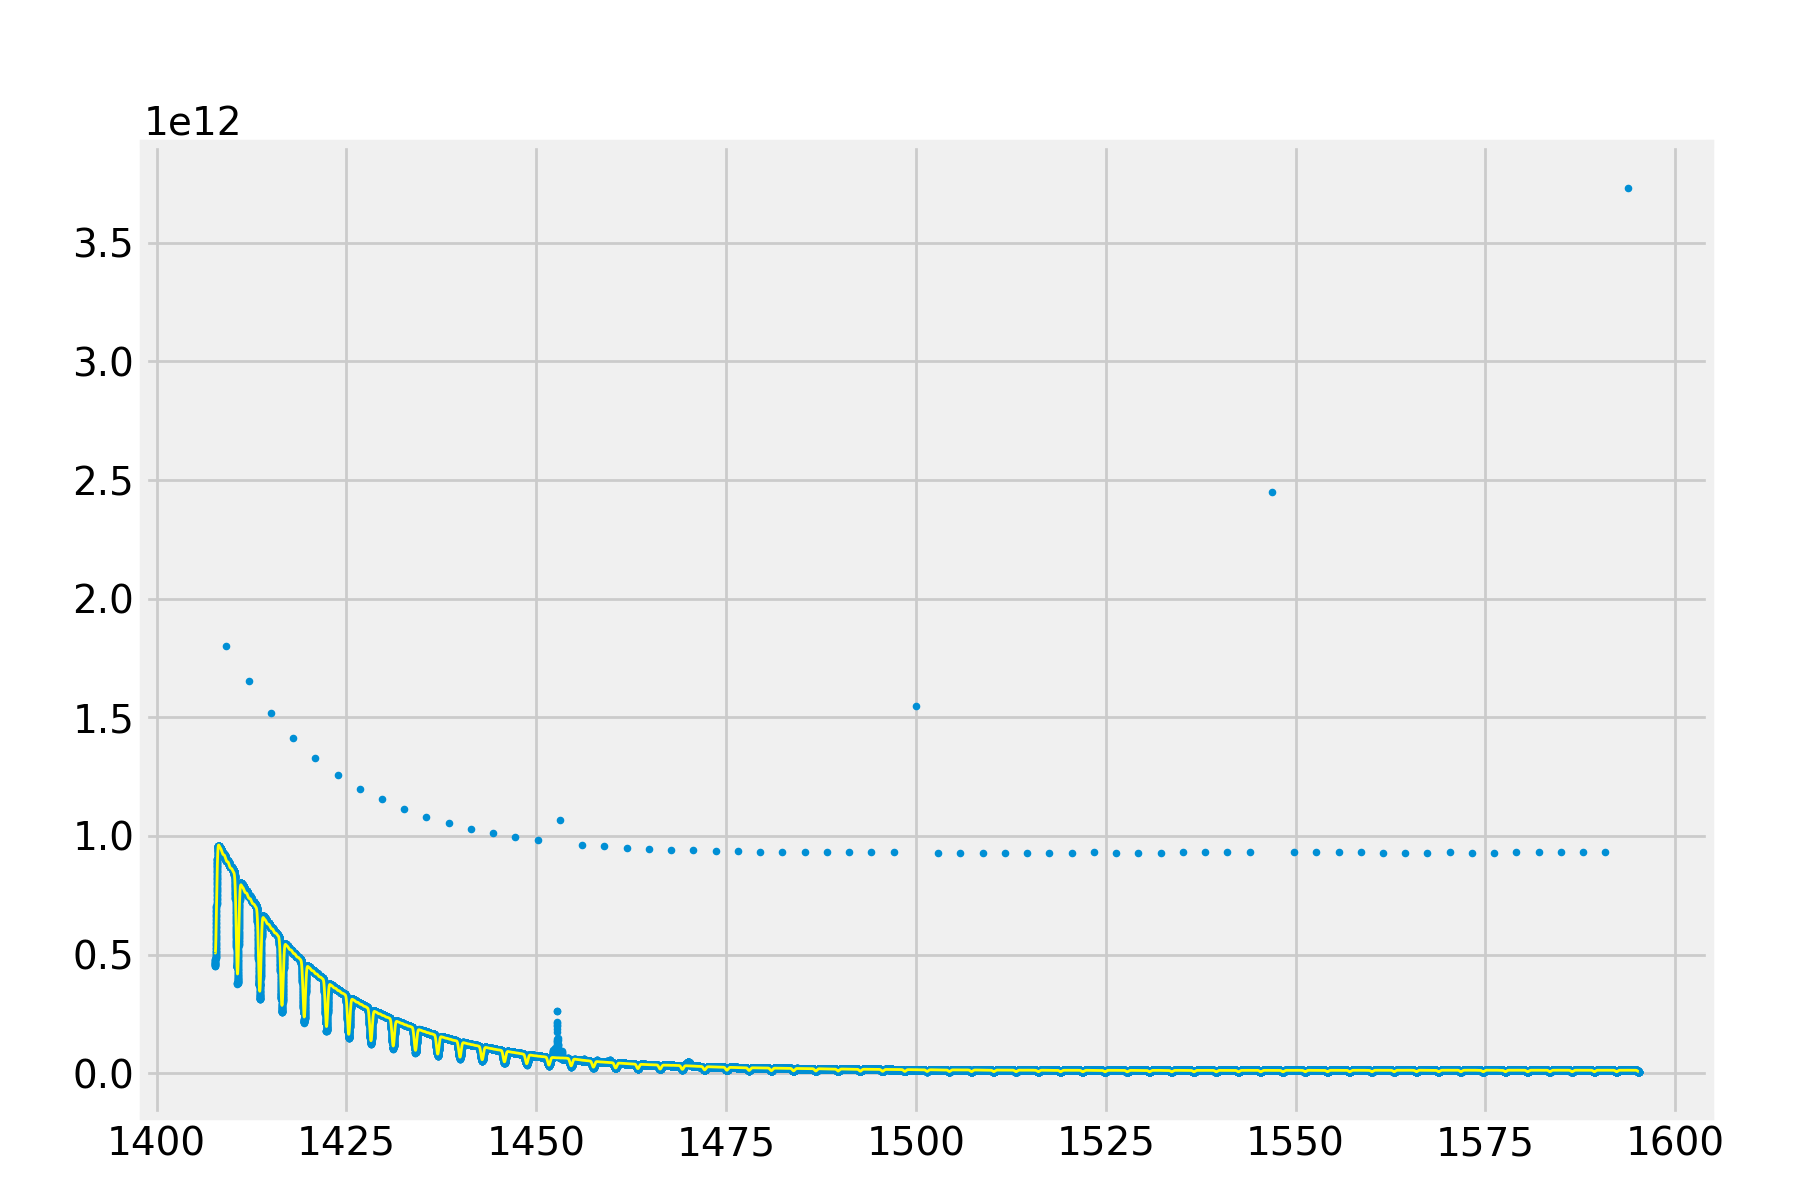

In [19]:
%matplotlib notebook
plt.figure(figsize=(9,6))
plt.scatter(freqs, data, s=5)
plt.plot(freqs, fit, linewidth=1, color='yellow')

# 3. Reducing the Spectrum and Obtaining Thresholded Hits

Once we have our fit, we would like to somehow "remove" it from the spectrum in order to isolate the narrow-band features. For this purpose, I have chosen to define a "reduced spectrum" by taking the residuals and then dividing by the fit itself. In equation form, where $y(x)$ is the power value at a given frequency value $x$:

$$
y_{reduced}(x) = \dfrac{y_{actual}(x)-y_{fit}(x)}{y_{fit}(x)}
$$

For the file we have been working with so far, the reduced spectrum looks like this:

<IPython.core.display.Javascript object>


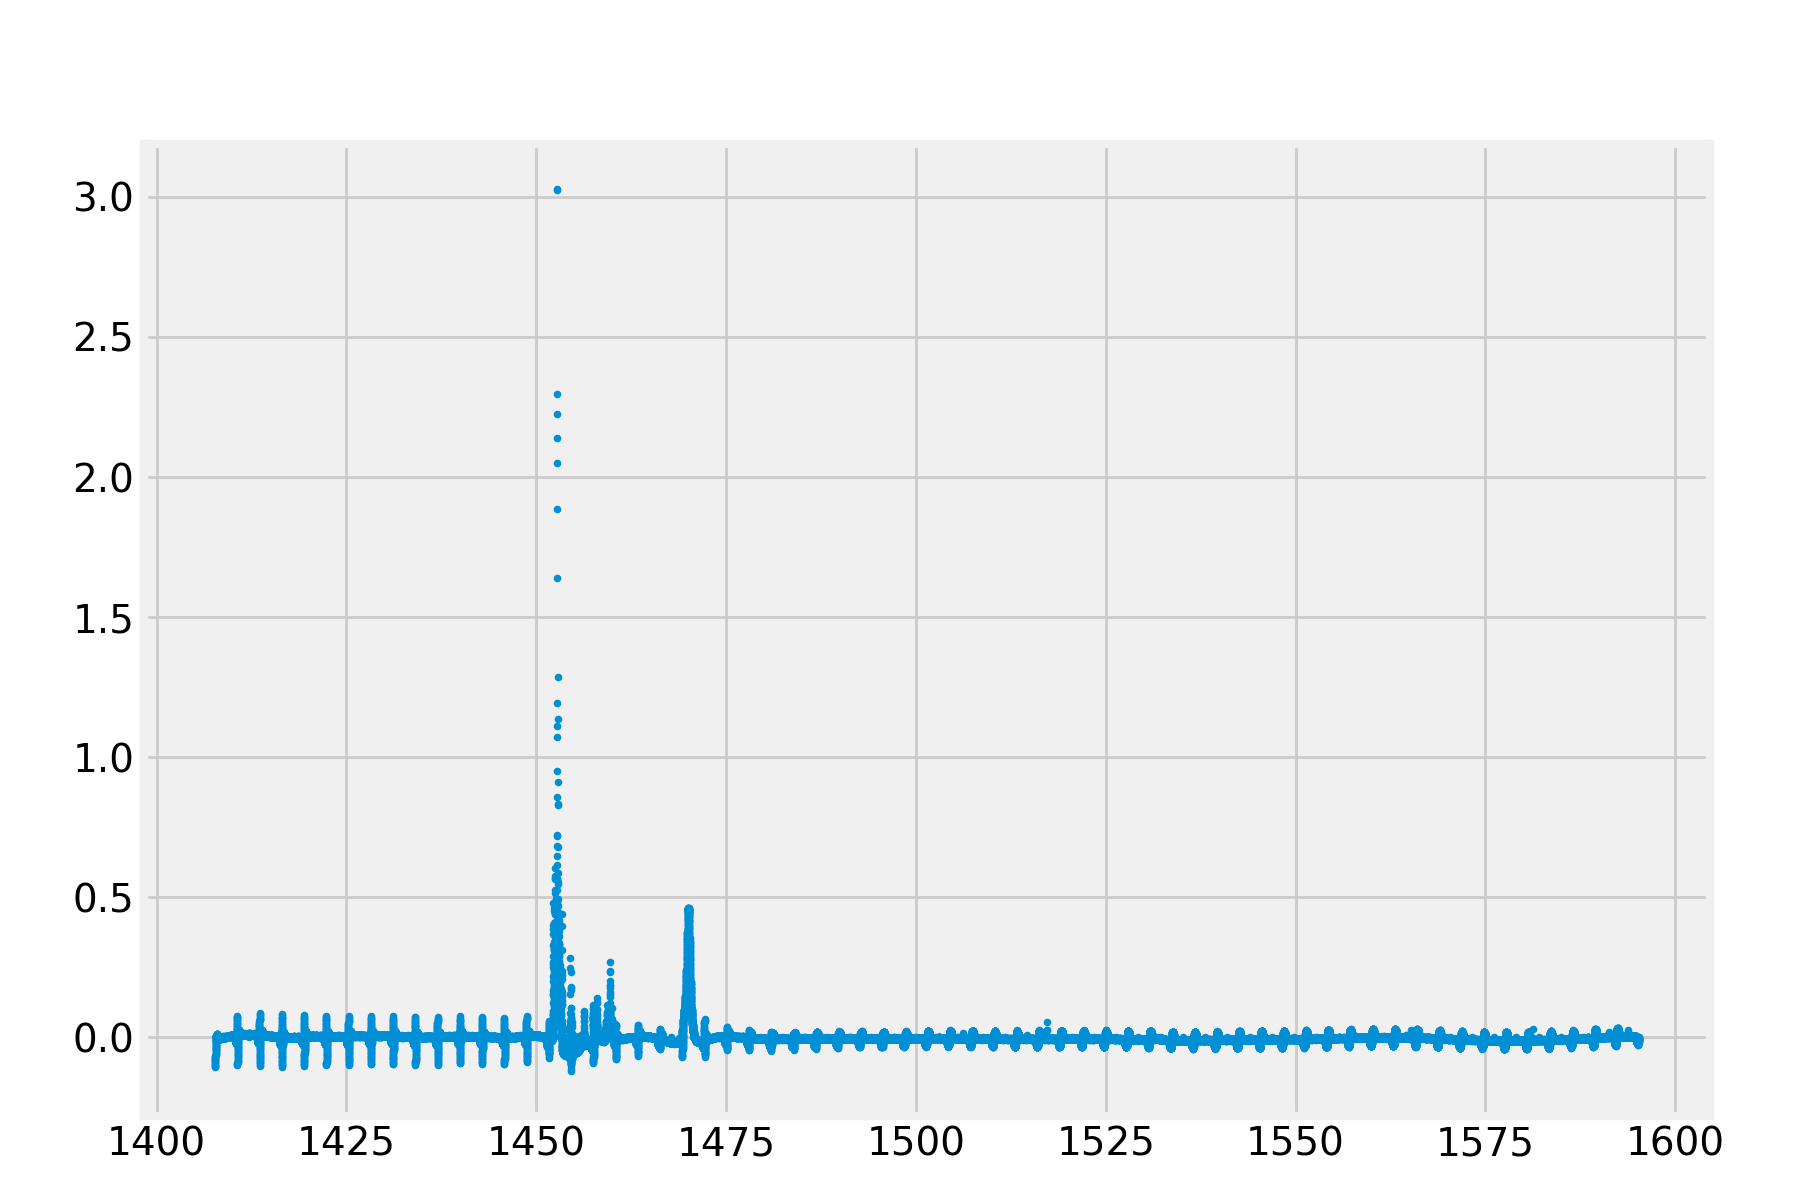

In [21]:
reduced_spec = (data-fit)/fit

#Manually remove the spikes 
last_index = len(freqs)-1
spikes = np.arange(511, last_index, 1024) #Indices of DC spikes
reduced_spec[spikes] = 0

%matplotlib notebook
plt.figure(figsize=(9,6))
plt.scatter(freqs, reduced_spec, s=5)

Since the fit is not perfect, there is unfortunately some leftover artificial periodicity in the reduced spectrum. Nevertheless, this reduced spectrum is still much quieter than the original and we clearly see the features of interest.

We can pick out these features by using a signal-to-noise thresholding procedure. The first step is to define the "noise" in the spectrum. I do this by finding the "quietest" coarse channel in the reduced spectrum (i.e. the one in which the standard deviation is smallest), and then the standard deviation in that coarse channel is taken to be the "noise", as it is a reasonable measure of the background variability in the spectrum. Then each value in the reduced spectrum is divided by the noise value to get an SNR. 

Below I find the noise for this spectrum and plot the SNRs.

<IPython.core.display.Javascript object>


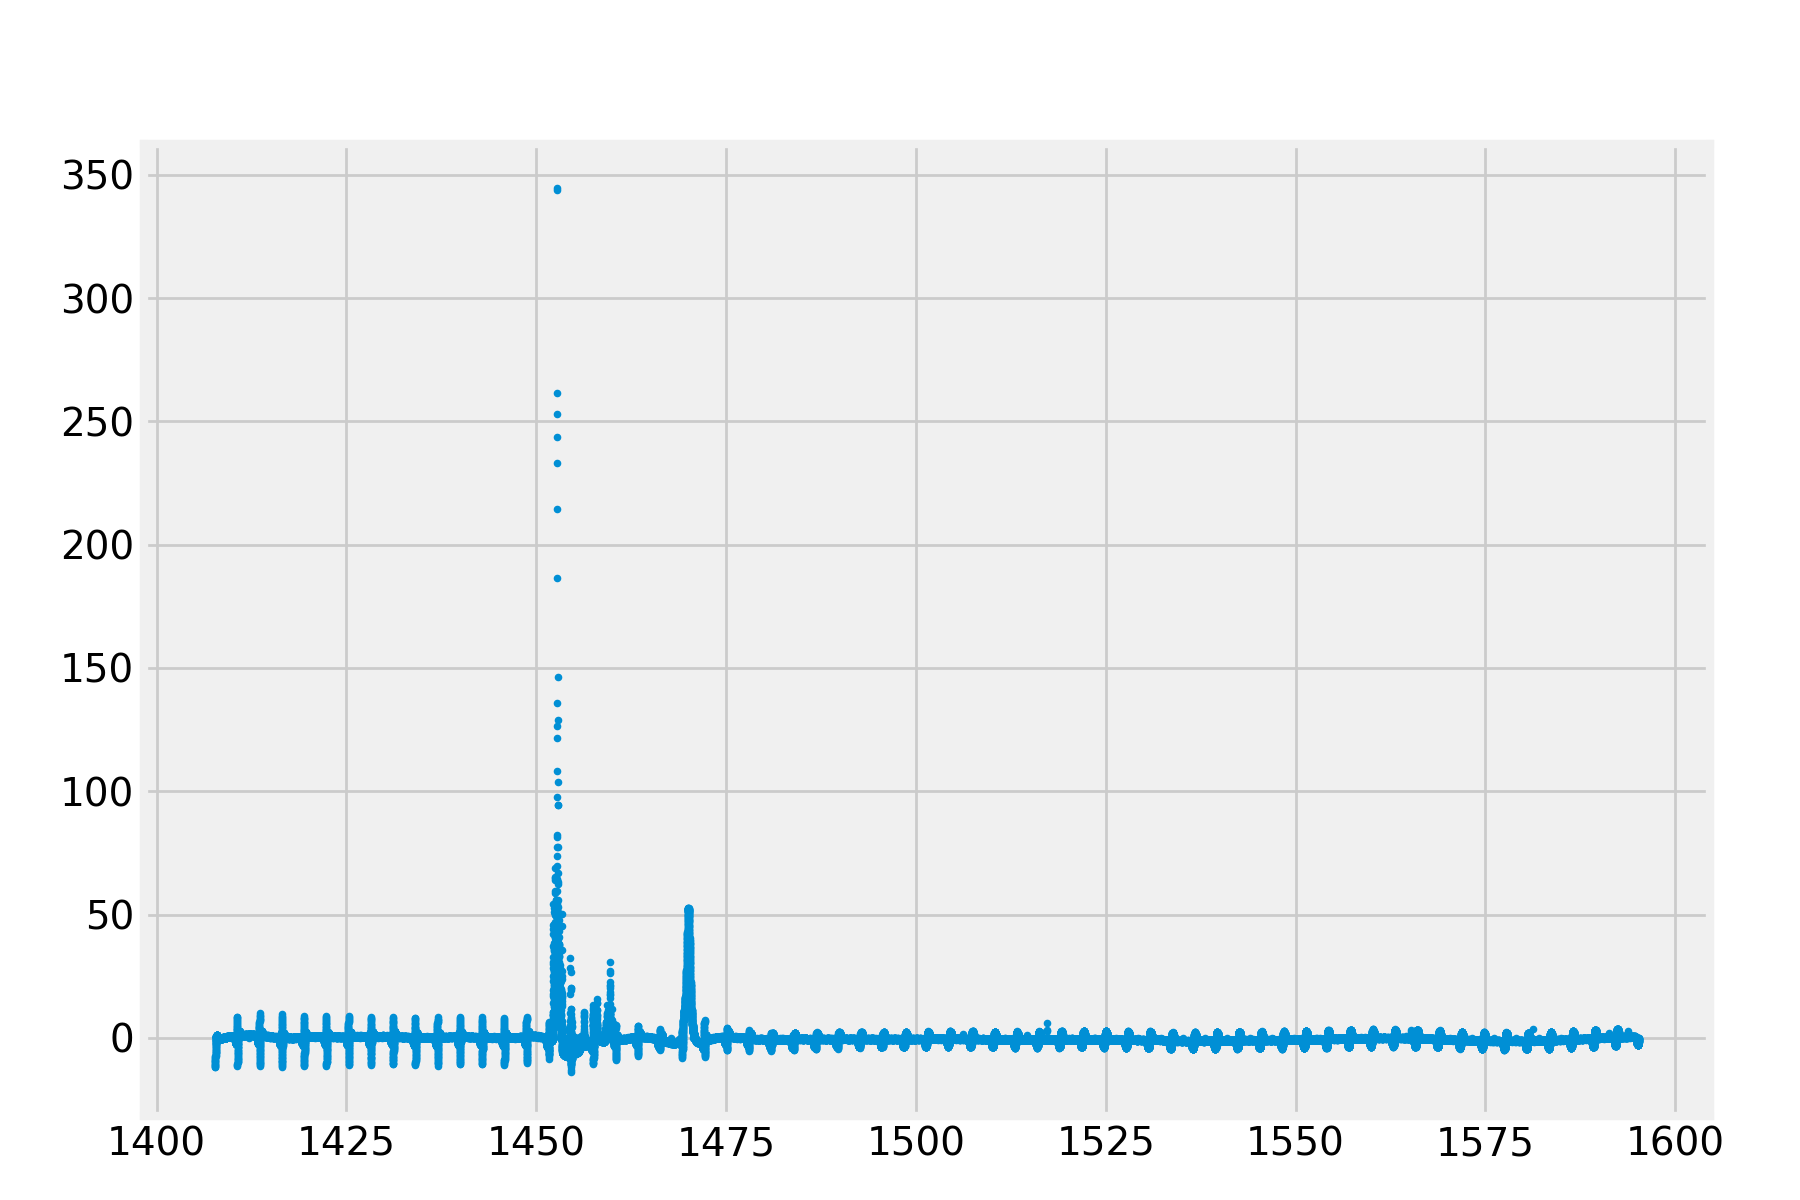

In [51]:
#Determine noise baseline  
num_CCs = int(len(reduced_spec)/1024) #Number of coarse channels
coarsechans = np.split(np.arange(len(reduced_spec)), num_CCs) #List of indices grouped by coarse channel
chansigmas = []
for chan in coarsechans:
    chansigmas.append(np.std(reduced_spec[chan]))
noise = np.min(chansigmas)
SNRs = reduced_spec/noise

%matplotlib notebook
plt.figure(figsize=(9,6))
plt.scatter(freqs, SNRs, s=5)

Now that we have SNRs, it is easy to threshold these values to identify the features of interest. Zooming in, we can see that the amplitude of the artificial periodicity induced by the imperfection of the fitting extends up to an SNR of about 10. So, when thresholding this spectrum, we might set our threshold at something like 15 or 20 to ensure we do not pick up artifacts.

**Thus the closeness of the fitting effectively sets the sensitivity limit of the thresholder.** At present, the fitting procedure is highly imperfect primarily because the detrending procedure is imperfect; if it could be improved, the sensitivity would be greatly improved as well.

In any case, below we create a function that will generate a fit to a file, threshold it, and return the information on the frequency bins above the threshold.

In [59]:
def power_threshold(file, integration=None, SNR=None, given_fit=None, diag=False):
    if SNR is None:
        raise ValueError("Please provide an SNR threshold.")
    SNR = float(SNR)

    #Get fit                                                                                                                                                                             
    if given_fit is None:
        freqs, data, fit = fit_file_0002(file, integration=integration)
    else:
        fil = Filterbank(file, t_start=integration, t_stop=integration+1)
        freqs = fil.freqs
        fit = given_fit
        if integration is None:
            data = np.sum(fil.data, axis=0)[0]
        else:
            data = fil.data[0][0]

    fit = np.array(fit)
    data = np.array(data)

    #if diag:
        #print "Making diagnostic plots..."
        #diagnostic_plots(file, freqs, data, fit)

    #Get DC spikes                                                                                                                                                                       
    last_index = len(freqs)-1
    spikes = np.arange(511, last_index, 1024)

    num_CCs = int(len(freqs)/1024)
    coarsechans = np.split(np.arange(len(freqs)), num_CCs)
    
    reduced_spec = (data - fit)/fit
    reduced_spec[spikes]=0

    #Determine noise baseline                                                                                                                                                            
    chansigmas = []
    for chan in coarsechans:
        chansigmas.append(np.std(reduced_spec[chan]))
    noise = np.min(chansigmas)

    #Determine hits information                                                                                                                                                          
    threshold = SNR*noise
    idx_hits = np.where(reduced_spec > threshold)[0] #Indices of "hits"
    hits_freqs = freqs[idx_hits]
    hits_powers = data[idx_hits]
    SNRs = np.array([value/noise for value in reduced_spec])
    hits_SNRs = SNRs[idx_hits]
    target = read_header(file)['source_name'].split('_')[0] #Remove "_OFF" if it is erroneously in target name 
    
    #Get date                                                                                                                                                                            
    if integration is None:
        MJD = read_header(file)['tstart']
    else:
        tstart = read_header(file)['tstart'] #Start MJD of observation                                                                                                                   
        tsamp = read_header(file)['tsamp']/86400 #Sampling time (in secs) divided by secs/day gives fractional MJD                                                                     
        MJD = tstart + tsamp*integration

    #Assemble hits into tuples                                                                                                                                                           
    hits = zip(hits_freqs, hits_powers, hits_SNRs)
    return {'target':target,
            'MJD':MJD,
            'hit_schema': 'freq, power, SNR (found via reduced spectrum i.e. (data-fit)/fit)',
            'hits':hits,
            'num_hits':len(hits),
            'noise':noise,
            'integration':integration}

power_threshold(file, SNR=70)

No integration number provided. Fitting summed spectrum...
Fitting to a coarse channel to find optimal phase and offset...
Found phase and offset. Constructing full spectrum Fourier fit...
Done fitting.



{'MJD': 57511.25782407408,
 'hit_schema': 'freq, power, SNR (found via reduced spectrum i.e. (data-fit)/fit)',
 'hits': [(1452.7316093444824, 1.0738976e+11, 73.563726970381239),
  (1452.7344703674316, 1.1239938e+11, 82.286564893439873),
  (1452.7373313903809, 1.0969499e+11, 77.553351454336692),
  (1452.7573585510254, 1.121088e+11, 81.642981619480395),
  (1452.7602195739746, 1.3778561e+11, 126.37768796818753),
  (1452.7630805969238, 1.431448e+11, 135.69596267393999),
  (1452.765941619873, 1.2132506e+11, 97.650872282717927),
  (1452.7716636657715, 1.2747638e+11, 108.33106501289427),
  (1452.7745246887207, 1.9923434e+11, 233.32395755622645),
  (1452.7773857116699, 2.6279787e+11, 344.02111798103113),
  (1452.7802467346191, 2.6313818e+11, 344.5753042401771),
  (1452.7831077575684, 2.1535806e+11, 261.31887273375867),
  (1452.7859687805176, 1.8844385e+11, 214.41578438254916),
  (1452.7888298034668, 2.0520213e+11, 243.57270222060578),
  (1452.791690826416, 2.1074559e+11, 253.19751312209806),
 

I used a rather high threshold just to limit the number of hits for convenience purposes. The function returns a dictionary with information about the file and the hits. Most are self-explanation, such as "integration", "target", "num_hits", etc. "Noise" is the aforementioned noise value in the *reduced spectrum*. "hits" is a list of tuples. Each tuple represents one "hit", i.e. one frequency bin that was above the threshold, and the tuple contains three members: the frequency, the actual power value in the original spectrum (if no integration was provided, this value is summed over time), and the SNR in the reduced spectrum. "hit_schema" just explains the meaning of the values in each of those fields.

## UNDER CONSTRUCTION

In [ ]:
LHS1140 = Filterbank('spliced_blc0001020304050607_guppi_57774_70844_LHS1140_0002.gpuspec.0002.fil')
LHSfreqs = LHS1140.freqs
LHSdata = LHS1140.data[0][0]

xs, ys, spline = trend_spline(LHSfreqs, np.log(LHSdata))
plt.figure(figsize=(9,6))
plt.scatter(LHSfreqs, np.log(LHSdata), s=4)
#plt.plot(LHSfreqs, spline(LHSfreqs), color='red', linewidth=2)
#plt.scatter(xs, ys, s=12, color='orange', zorder=3); plt.tight_layout()